In [1]:
import torch

In [2]:
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

encoded_train, encoded_valid  = np.load(os.path.join(root_encoded,'encoded_%s_conv.npy'%(label_2)), allow_pickle=True)

decoded_train, decoded_valid  = np.load(os.path.join(root_decoded,'decoded_%s_conv.npy'%(label_2)), allow_pickle=True)

In [6]:
model = torch.load(os.path.join(root_models,'conditional_SINF_%s_convAE1'%(label_2)))

In [7]:
train,valid,le = pickle.load(open(os.path.join(root_model_data,'SDSS_DR16_preprocessed_relabeled.pkl'),'rb'))

In [31]:
valid.keys()

odict_keys(['spec', 'mask', 'noise', 'z', 'RA', 'DEC', 'class', 'subclass', 'SN', 'MJD', 'plate', 'fiber', 'mean', 'std', 'labels', 'new_inf_labels', 'new_label', 'new_logp', 'old_logp', 'logp_marg_flat_prior', 'logp_max', 'logp_marg_prior'])

In [8]:
train_x = torch.Tensor(np.squeeze(encoded_train)).to(device) 
train_y = torch.Tensor(train['new_inf_labels']).to(torch.long).to(device)

valid_x = torch.Tensor(np.squeeze(encoded_valid)).to(device) 
valid_y = torch.Tensor(valid['new_inf_labels']).to(torch.long).to(device)

In [14]:
for data,dd  in zip([train_x,valid_x],[train,valid]):
    px = np.zeros((16,len(data)))
    for ii in range(16):
        px[ii]      = model.evaluate_density(data,ii*torch.ones((len(data))).to(device)).cpu().numpy()
    dd['logp_marg_flat_prior'] = np.sum(px,axis=0)/16.
    dd['logp_max'] = px.max(axis=0)

In [30]:
for data,dd  in zip([train_x,valid_x],[train,valid]):
    px = np.zeros((16,len(data)))
    for ii in range(16):
        px[ii]      = model.evaluate_density(data,ii*torch.ones((len(data))).to(device)).cpu().numpy()
    dd['new_label'] = px.argmax(axis=0)

In [31]:
counts = np.unique(dd['new_label'], return_counts=True)[1]
prior  = np.log(counts/sum(counts))
print(prior)

[4.63463191e-01 7.46777428e-02 4.43569178e-02 7.37611000e-03
 7.87023775e-02 8.30707534e-04 2.85935262e-01 1.95645947e-02
 9.59610427e-04 7.10398167e-03 2.09109138e-03 2.87883128e-03
 8.30707534e-04 7.46204526e-03 5.72901747e-05 3.70953881e-03]


In [32]:
for data,dd  in zip([train_x,valid_x],[train,valid]):
    px = np.zeros((16,len(data)))
    for ii in range(16):
        px[ii]      = model.evaluate_density(data,ii*torch.ones((len(data))).to(device)).cpu().numpy()
    dd['logp_marg_prior'] = np.sum(px+prior[:,None],axis=0)

In [33]:
pickle.dump([train,valid,le],open(os.path.join(root_model_data,'SDSS_DR16_logp_results.pkl'),'wb'))

In [9]:
train,valid,le = pickle.load(open(os.path.join(root_model_data,'SDSS_DR16_logp_results.pkl'),'rb'))

In [10]:
masked={}

In [11]:
masked['train'] = np.ma.array(np.squeeze(train['spec']),mask=~np.squeeze(train['mask'].astype('bool')))
masked['valid'] = np.ma.array(np.squeeze(valid['spec']),mask=~np.squeeze(valid['mask'].astype('bool')))


In [12]:
clip =1 

In [13]:
df_train         = pd.DataFrame.from_dict(dict((k,train[k]) for k in ('MJD','fiber','plate','subclass','class', 'RA', 'DE') if k in train))
df_train['mask_fracs'] = np.sum(~train['mask'].astype('bool'),axis=1)/1000
df_train['z']    = train['z']
noise            = np.ma.array(np.squeeze(train['noise']),mask=~np.squeeze(train['mask'].astype('bool')))
masked_array     = np.ma.array(np.squeeze(train['spec'])-np.squeeze(decoded_train), mask=~np.squeeze(train['mask'].astype('bool')))
df_train['recon_error_std'] = np.ma.std(masked_array**2*noise,axis=1)

df_train['recon_error'] = np.ma.mean(np.ma.clip(masked_array**2*noise,a_min=np.zeros_like(df_train['recon_error_std'].to_numpy())[:,None],a_max=clip*df_train['recon_error_std'].to_numpy()[:,None]),axis=1)

df_train['max_recon_error'] = np.ma.max(np.ma.array(np.squeeze(train['spec'])-np.squeeze(decoded_train),mask=~np.squeeze(train['mask'].astype('bool')))**2*noise,axis=1)
df_train = df_train.reset_index()

In [14]:
df_valid         = pd.DataFrame.from_dict(dict((k,valid[k]) for k in ('MJD','fiber','plate','subclass', 'RA', 'DE') if k in valid))
df_valid['mask_fracs'] = np.sum(~valid['mask'].astype('bool'),axis=1)/1000
df_valid['z']    = valid['z']
noise            = np.ma.array(np.squeeze(valid['noise']),mask=~np.squeeze(valid['mask'].astype('bool')))
df_valid['recon_error_std'] = np.ma.std(np.ma.array(np.squeeze(valid['spec'])-np.squeeze(decoded_valid),mask=~np.squeeze(valid['mask'].astype('bool')))**2*noise,axis=1)

df_valid['recon_error'] = np.ma.mean(np.ma.clip(np.ma.array(np.squeeze(valid['spec'])-np.squeeze(decoded_valid),\
mask=~np.squeeze(valid['mask'].astype('bool')))**2*noise,a_min=np.zeros_like(df_valid['recon_error_std'].to_numpy())[:,None],a_max=clip*df_valid['recon_error_std'].to_numpy()[:,None]),axis=1)

df_valid['max_recon_error'] = np.ma.max(np.ma.array(np.squeeze(valid['spec'])-np.squeeze(decoded_valid),mask=~np.squeeze(valid['mask'].astype('bool')))**2*noise,axis=1)
df_valid = df_valid.reset_index()

In [ ]:
Supernovas = pd.read_pickle('../forPub/Supernova_Sample.pkl')

NameError: name 'pd' is not defined

In [16]:
for df in [df_train, df_valid]:
    sns = df.merge(Supernovas, on=['MJD','plate','fiber'])
    df['supernova']=np.zeros(len(df['MJD']))
    df.loc[sns['index'],'supernova']=1

In [17]:
index = np.where(df_train['supernova']==True)[0]

In [18]:
len(index)

7

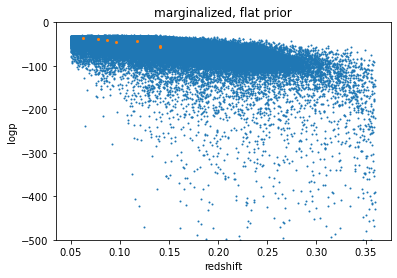

In [19]:
plt.title('marginalized, flat prior')
plt.scatter(df_train['z'],train['logp_marg_flat_prior'],s=1)
plt.scatter(df_train['z'][index],train['logp_marg_flat_prior'][index],s=4)
plt.ylim(-500,0)
plt.xlabel('redshift')
plt.ylabel('logp')
plt.show()

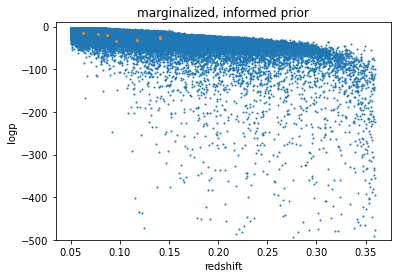

In [20]:
plt.title('marginalized, informed prior')
plt.scatter(df_train['z'],train['logp_marg_prior'],s=1)
plt.scatter(df_train['z'][index],train['logp_marg_prior'][index],s=4)

plt.ylim(-500,10)
plt.xlabel('redshift')
plt.ylabel('logp')
plt.show()

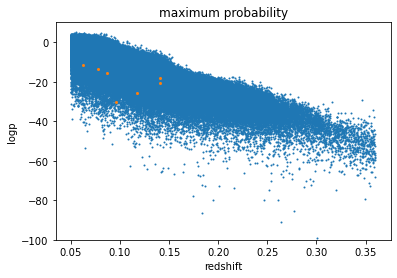

In [21]:
plt.title('maximum probability')
plt.scatter(df_train['z'],train['logp_max'],s=1)
plt.scatter(df_train['z'][index],train['logp_max'][index],s=4)
plt.ylim(-100,10)
plt.xlabel('redshift')
plt.ylabel('logp')
plt.show()

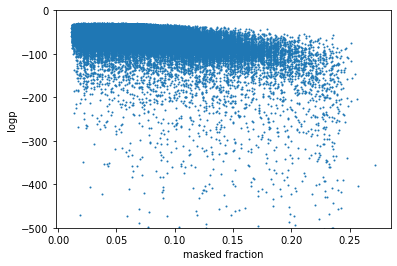

In [22]:
plt.scatter(df_train['mask_fracs'],train['logp_marg_flat_prior'],s=1)
plt.ylim(-500,0)
plt.xlabel('masked fraction')
plt.ylabel('logp')
plt.show()

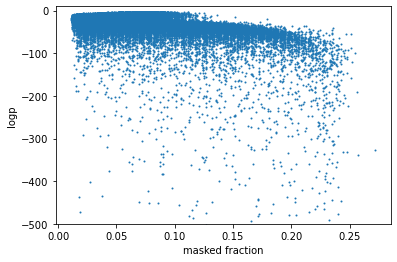

In [23]:
plt.scatter(df_train['mask_fracs'],train['logp_marg_prior'],s=1)
plt.ylim(-500,10)
plt.xlabel('masked fraction')
plt.ylabel('logp')
plt.show()

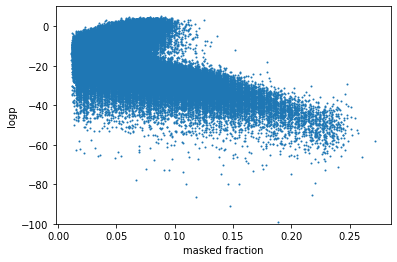

In [24]:
plt.scatter(df_train['mask_fracs'],train['logp_max'],s=1)
plt.ylim(-100,10)
plt.xlabel('masked fraction')
plt.ylabel('logp')
plt.show()

In [25]:
for dd1, dd2 in zip([df_train,df_valid],[train,valid]):
    for label in ['logp_max','logp_marg_prior','logp_marg_flat_prior']:
        dd1[label] = dd2[label]

In [27]:
def split_in_equal_bins(data, num_bins, sort_by, logp, frac):
    ppb  = len(data)//num_bins
    data = data.sort_values(sort_by)
    bin_edges = [0]
    outliers  = []
    for ii in range(num_bins):
        dd = data.iloc[ii*ppb:(ii+1)*ppb]
        bin_edges.append(dd[sort_by].iloc[-1])
        dd = dd.sort_values(logp)
        outliers.append(dd.iloc[0:int(np.ceil(ppb*frac))])
    return bin_edges, outliers

In [26]:
bin_edges, ood = split_in_equal_bins(df_valid, 10, 'z', 'logp_max', 0.0011)

In [27]:
ood[0].index

Int64Index([35733, 24819, 21025, 59421, 25557, 40614, 55045, 36984], dtype='int64')

In [37]:
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
new_wl            = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [46]:
df_valid.iloc[9]

index                       9.000000
MJD                     51877.000000
fiber                     531.000000
plate                     439.000000
subclass                    5.000000
RA                        122.861259
mask_fracs                  0.107000
z                           0.199040
recon_error_std            11.608801
recon_error                 2.152933
max_recon_error           310.317168
supernova                   0.000000
logp_max                  -40.013912
logp_marg_prior           -78.431976
logp_marg_flat_prior     -129.045069
Name: 9, dtype: float64

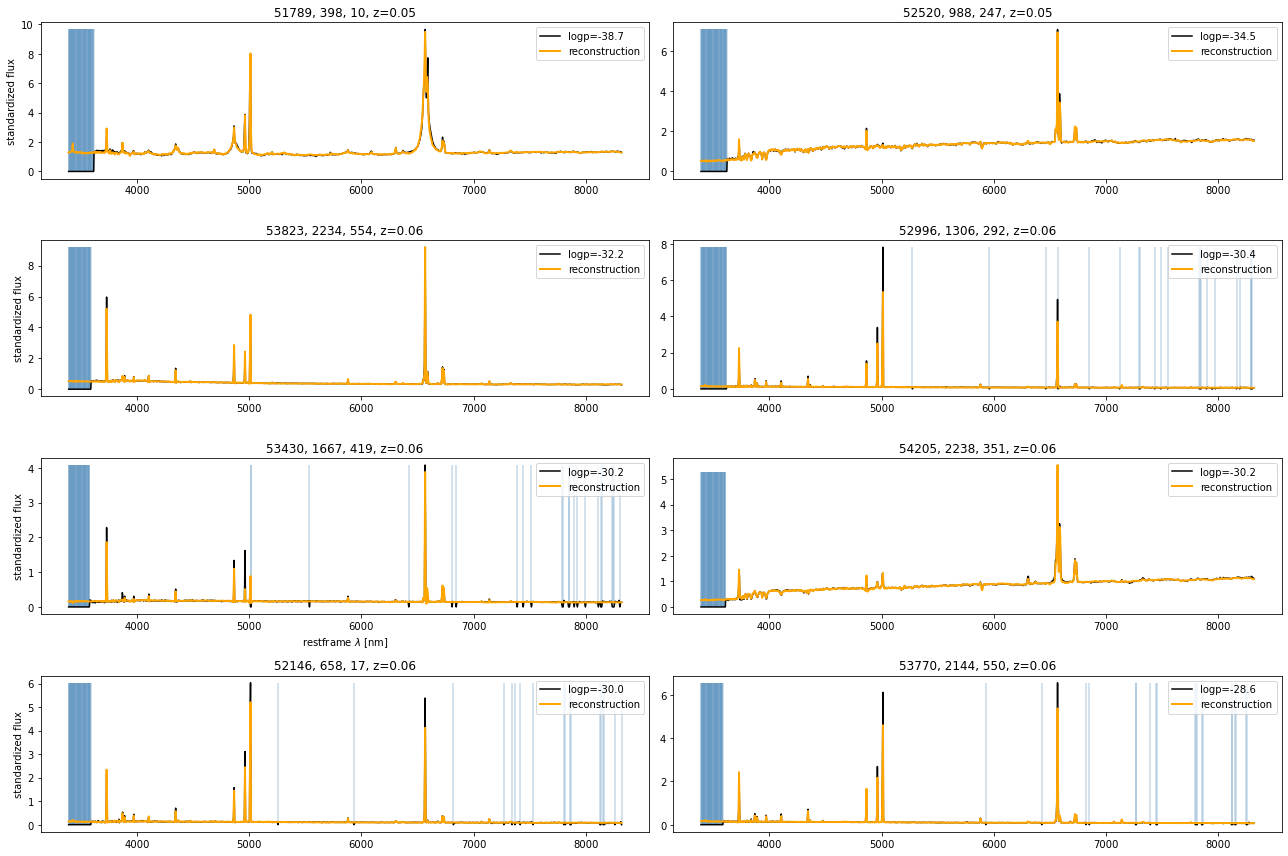

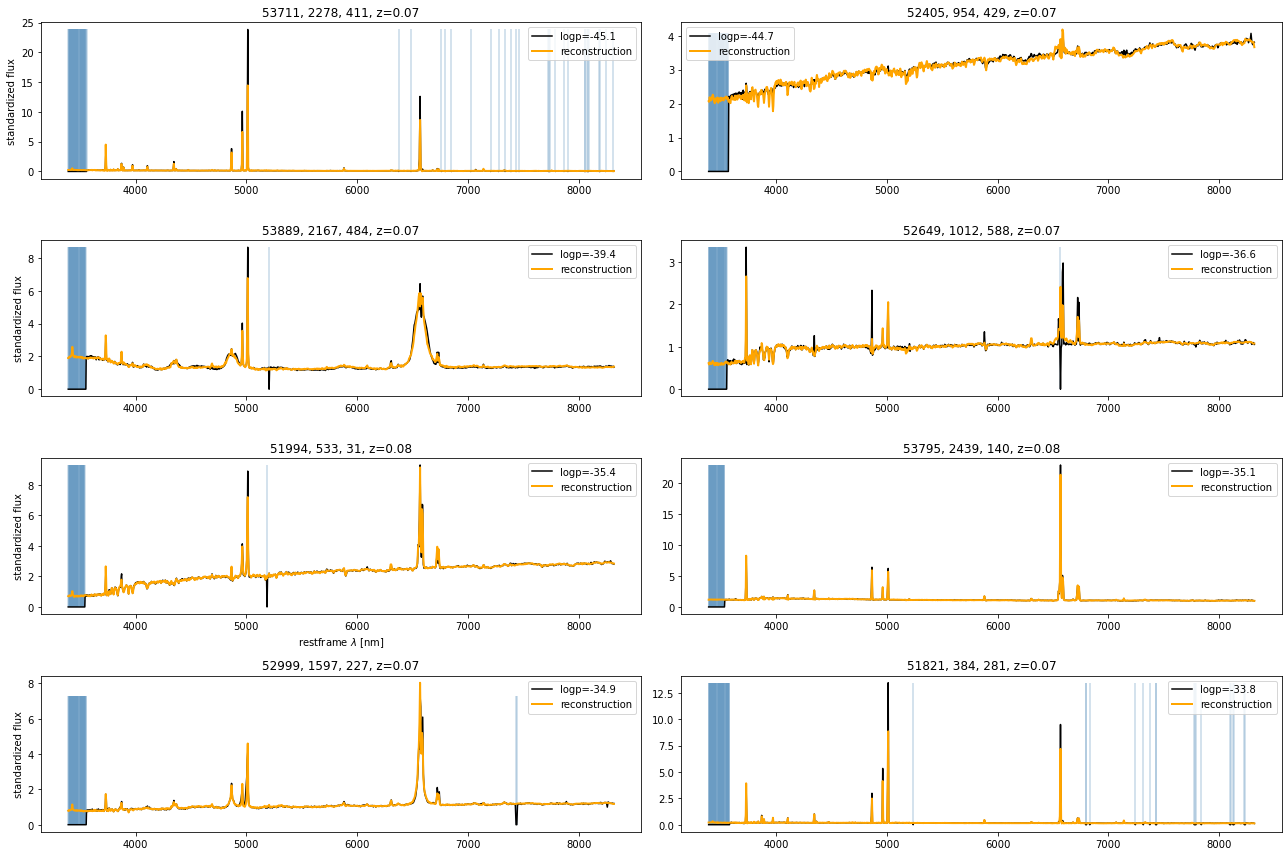

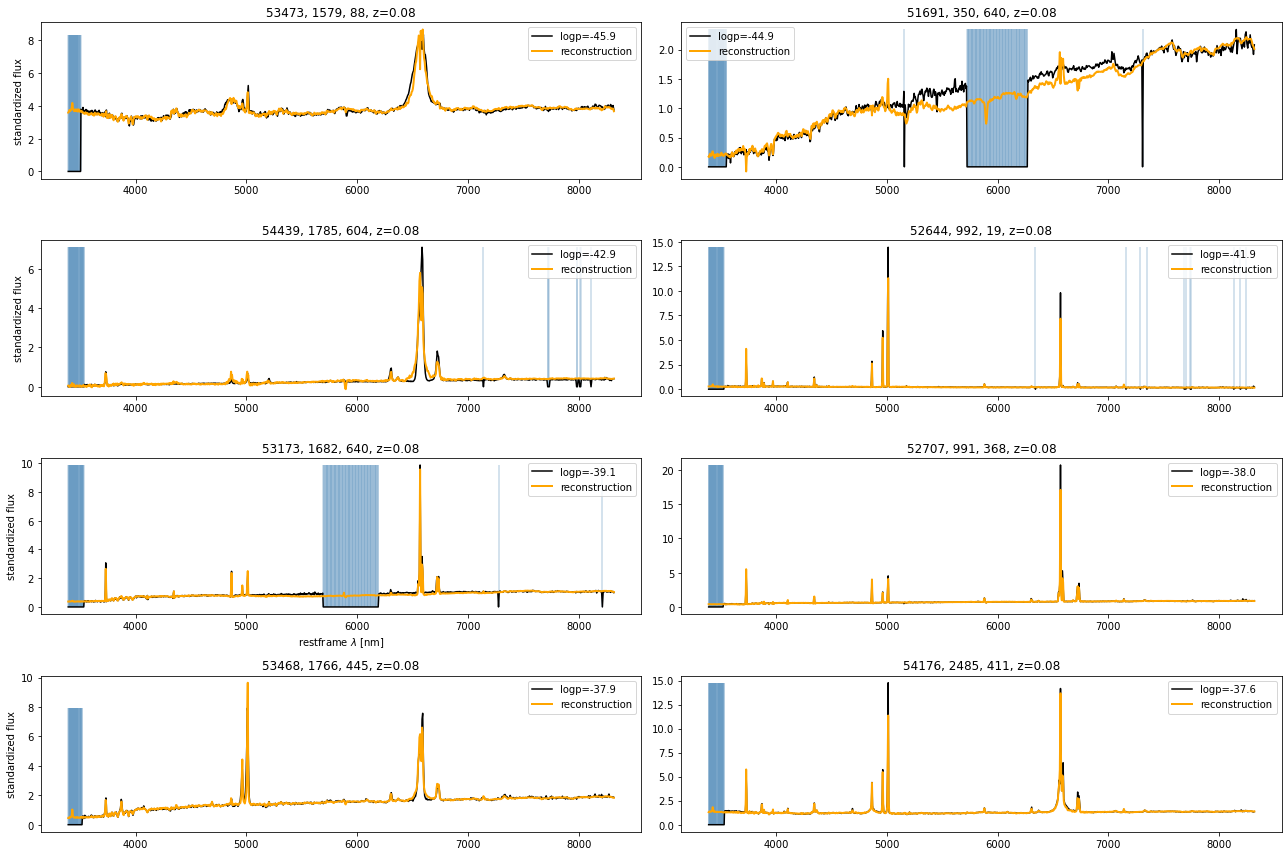

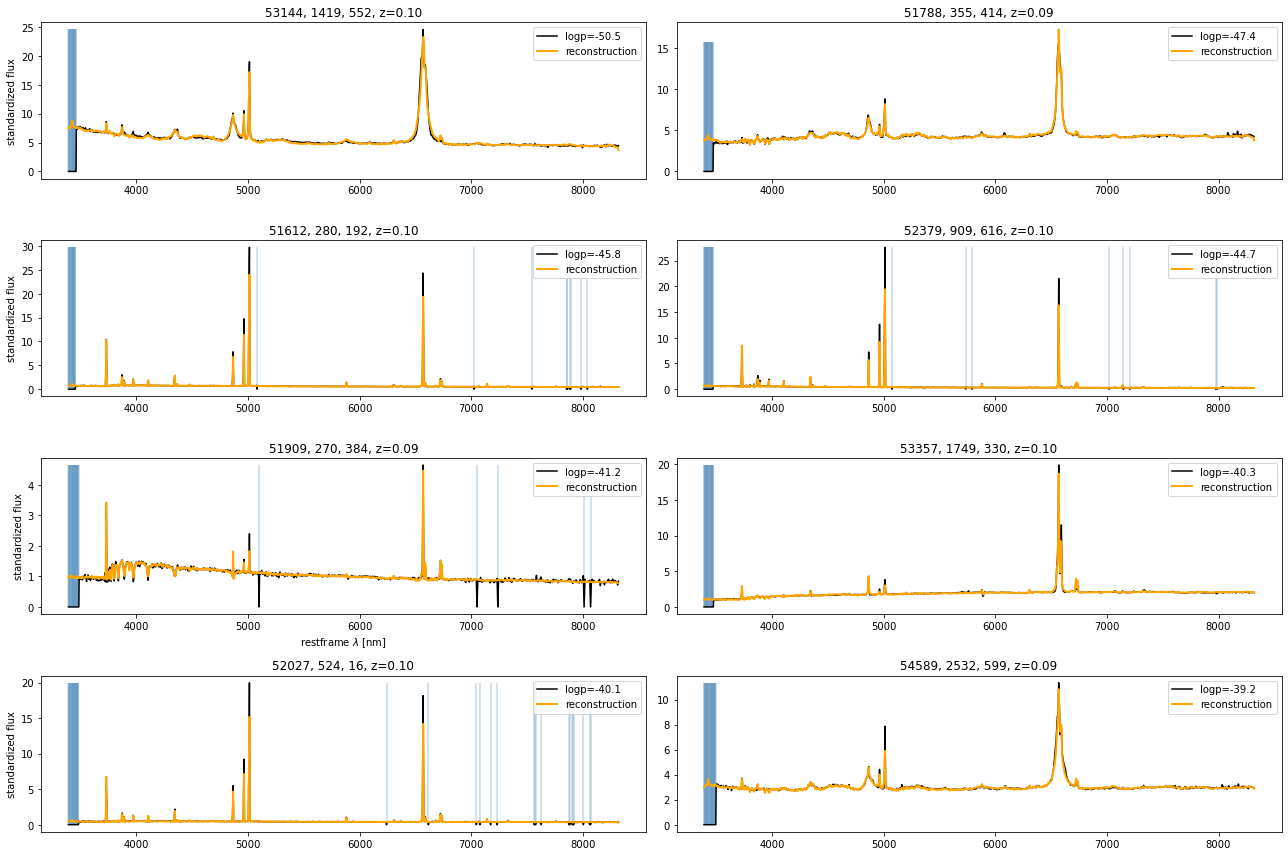

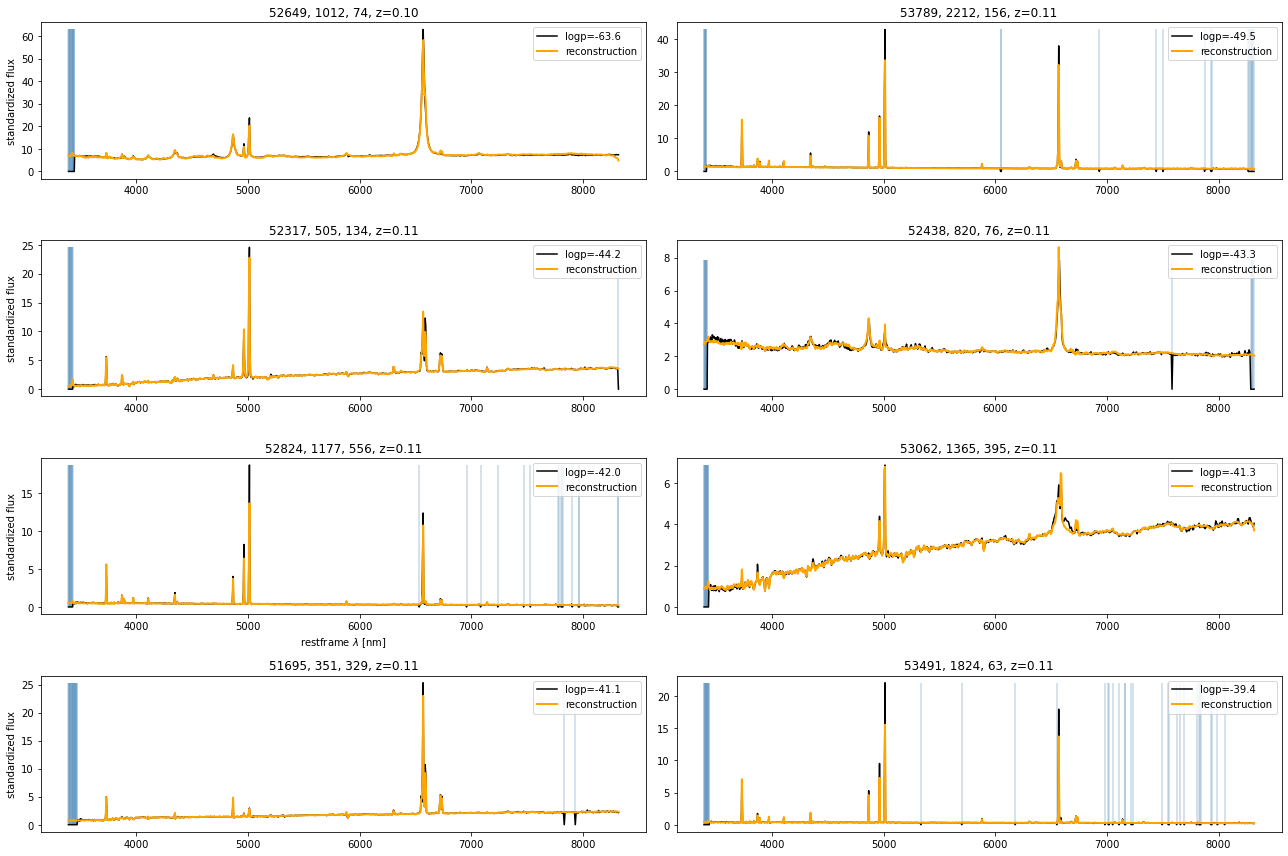

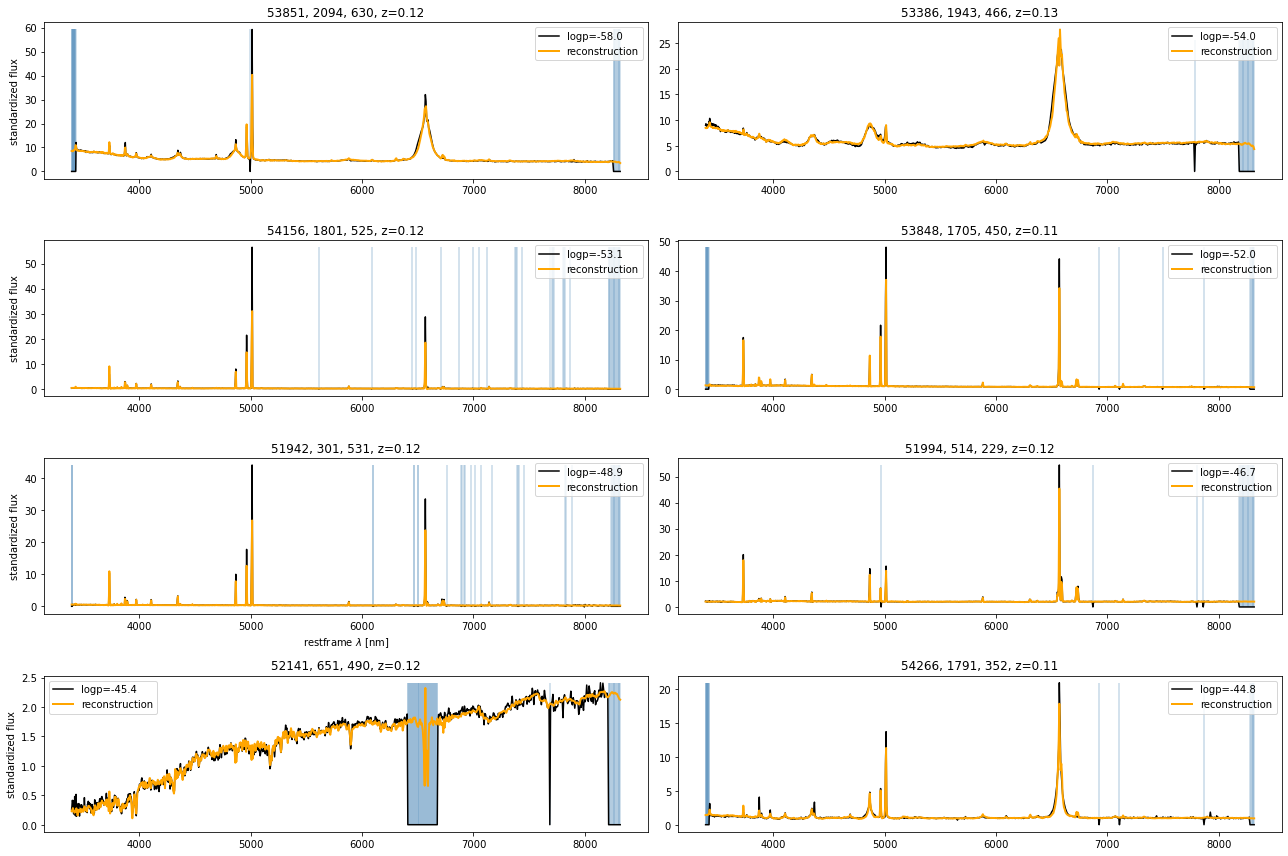

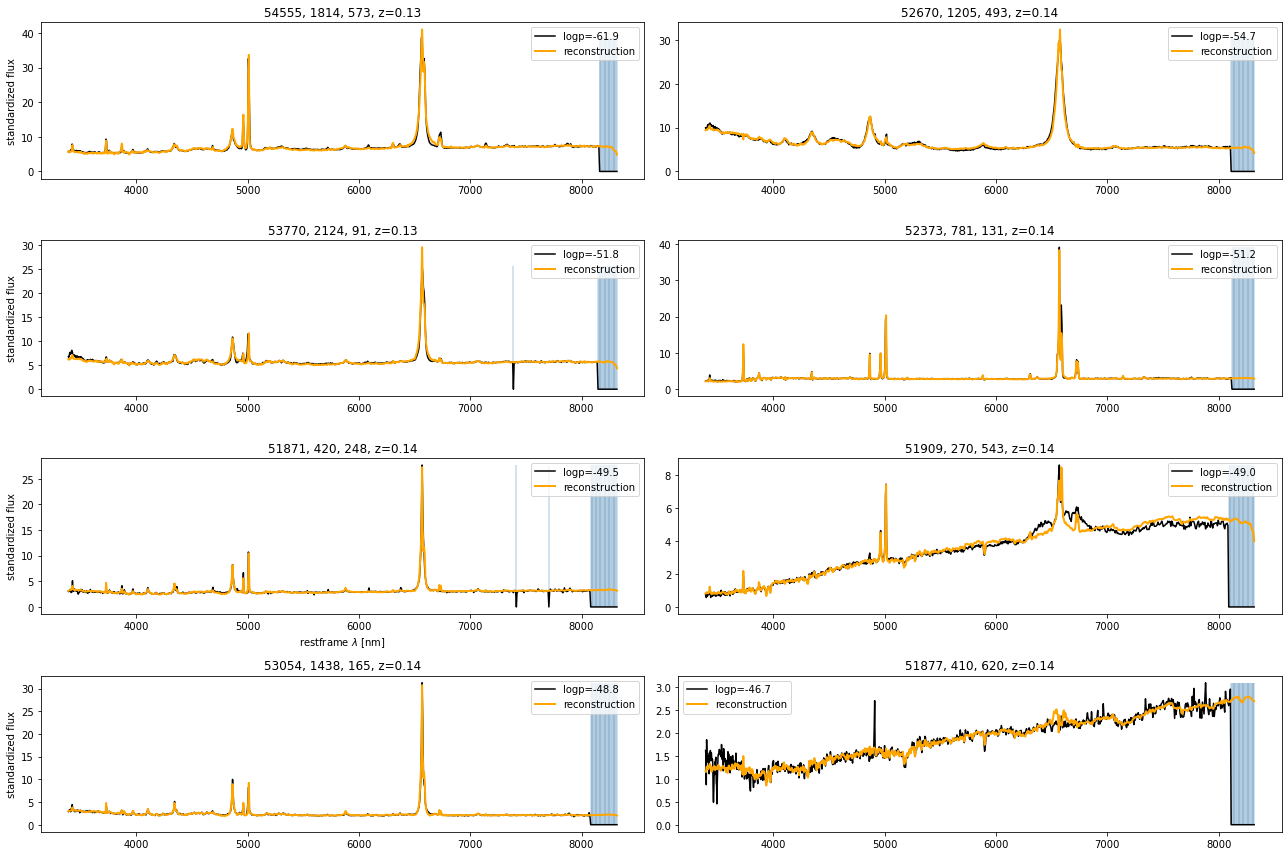

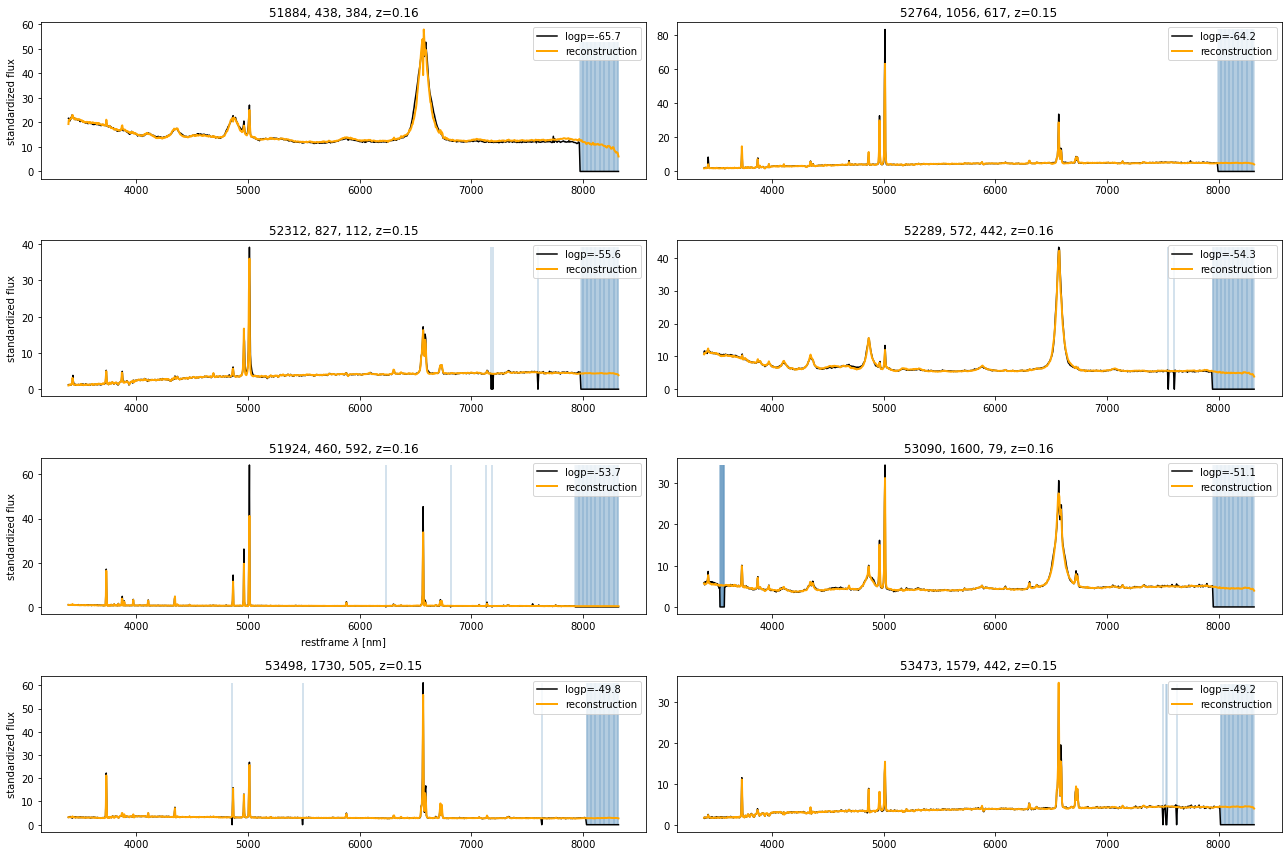

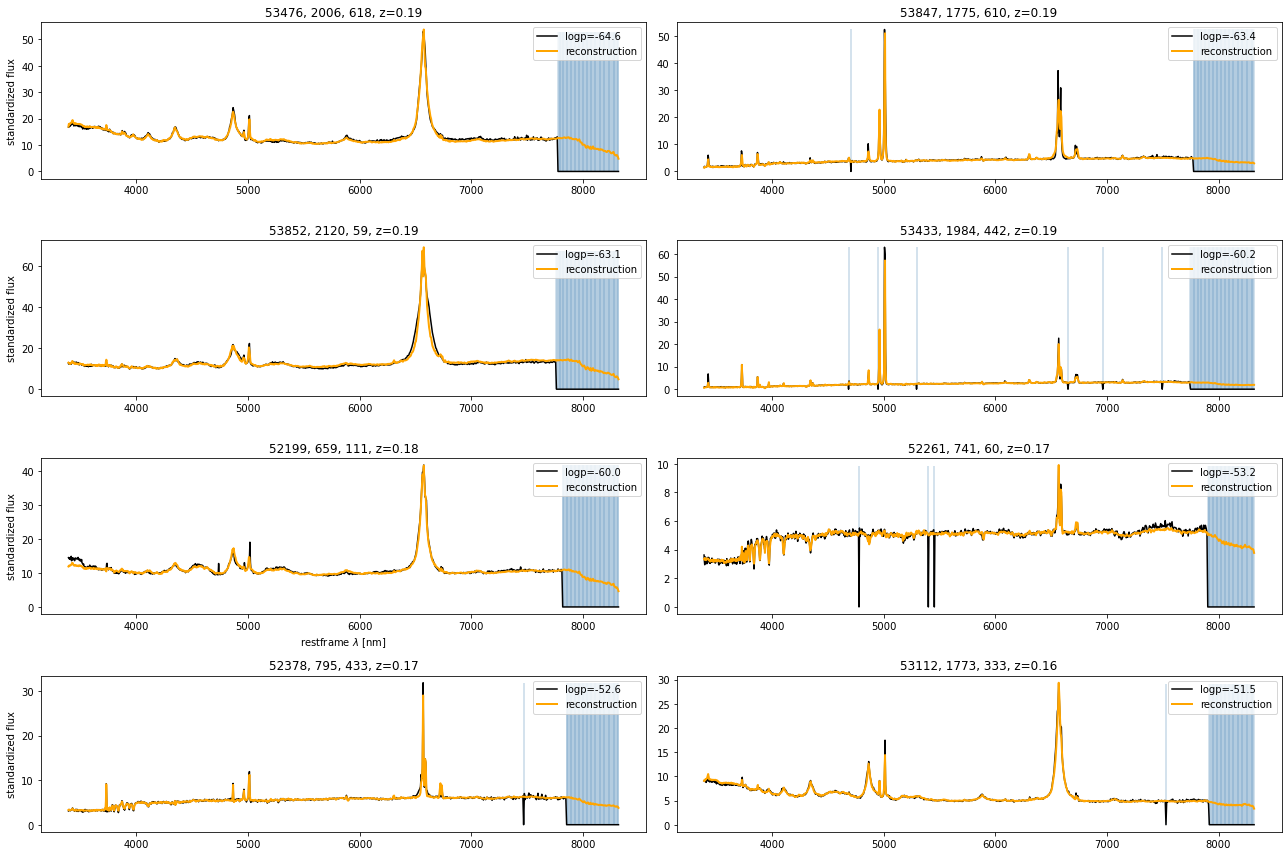

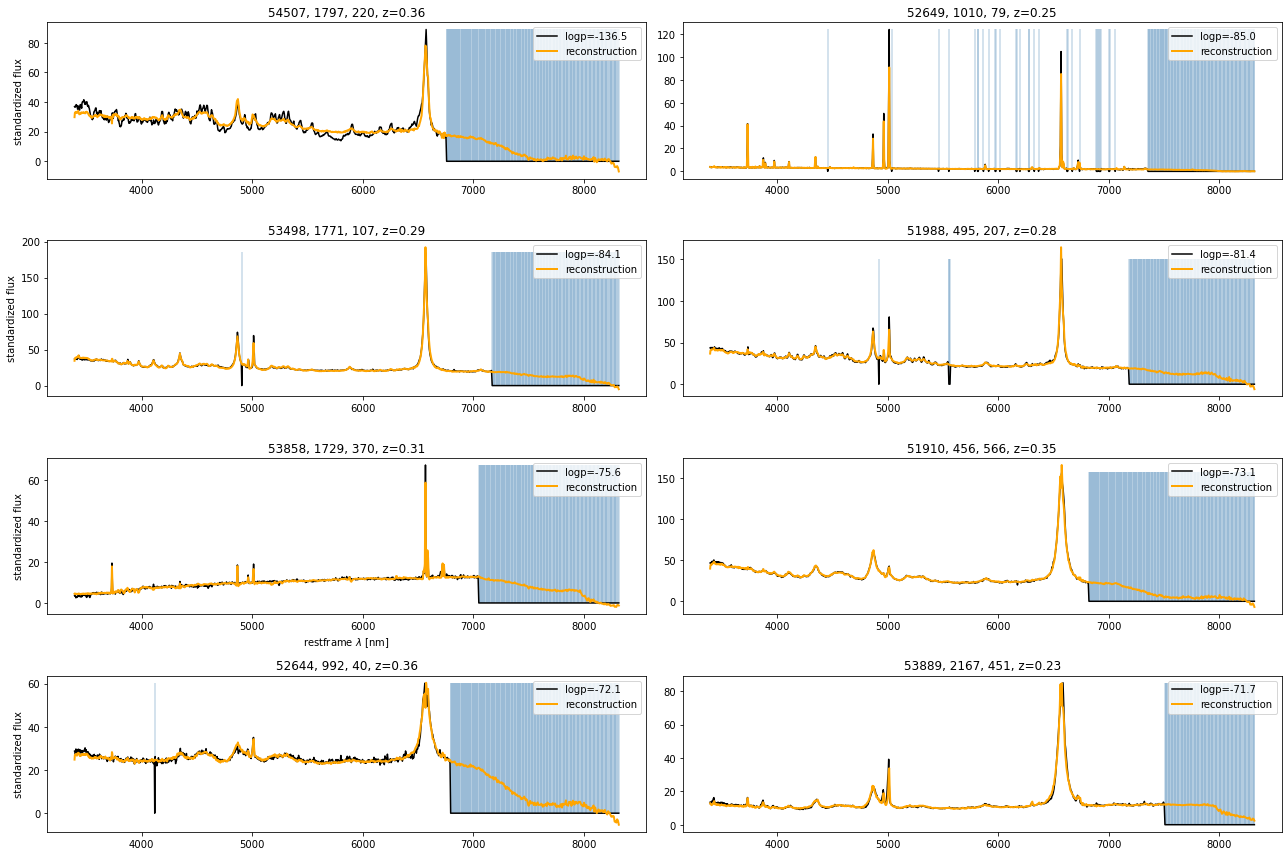

In [59]:
for ii in range(len(ood)):
    fi, ax = plt.subplots(len(ood[ii])//2,2,figsize=(18,12))
    ax     = ax.flatten()
    for jj in range(len(ood[ii])):
        data   = df_valid.iloc[ood[ii].index.values].reset_index()
        ax[jj].set_title('%d, %d, %d, z=%.2f'%(data['MJD'][jj],data['plate'][jj],data['fiber'][jj],data['z'][jj]))
        ax[jj].plot(new_wl[1:],valid['spec'][ood[ii].index.values][jj],label='logp=%.1f'%data['logp_max'][jj], color='black')
        ax[jj].vlines(x=new_wl[1:][np.squeeze(~valid['mask'][ood[ii].index.values][jj].astype(bool))], ymin=0,ymax=max(valid['spec'][ood[ii].index.values][jj]), color='steelblue',alpha=0.3)
        ax[jj].plot(new_wl[1:],np.squeeze(decoded_valid[ood[ii].index.values][jj]), label='reconstruction',ls='-', color='orange', lw=2)
        ax[jj].legend()
        if jj in [4,8]:
            ax[jj].set_xlabel(r'restframe $\lambda$ [nm]')
        if jj%2==0:
            ax[jj].set_ylabel(r'standardized flux')        
    plt.tight_layout()
    #plt.savefig(os.path.join(plotpath,'relabeled_retrained/logp/','logp_outliers_class_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
    plt.show()
    plt.close()

In [60]:
bin_edges, ood = split_in_equal_bins(df_valid, 10, 'z', 'logp_marg_flat_prior', 0.0011)

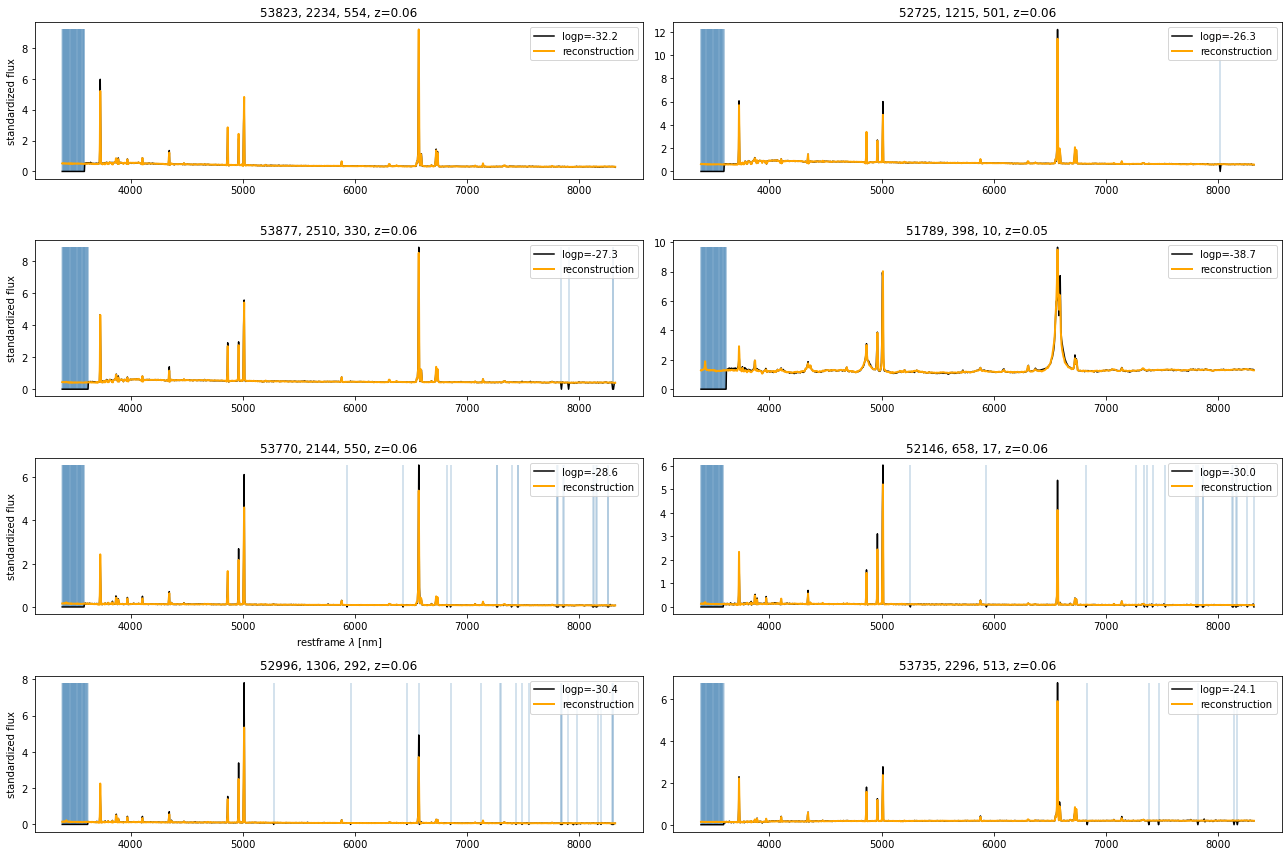

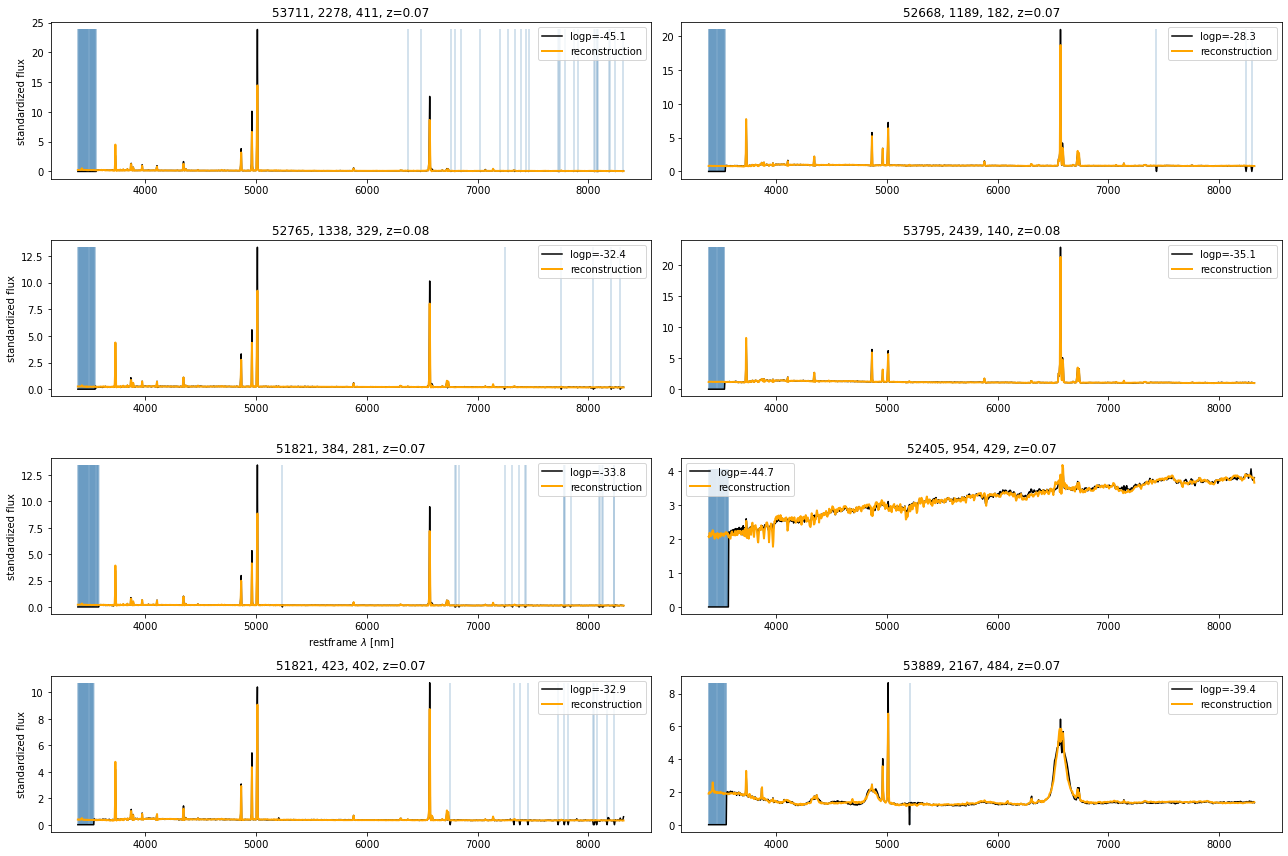

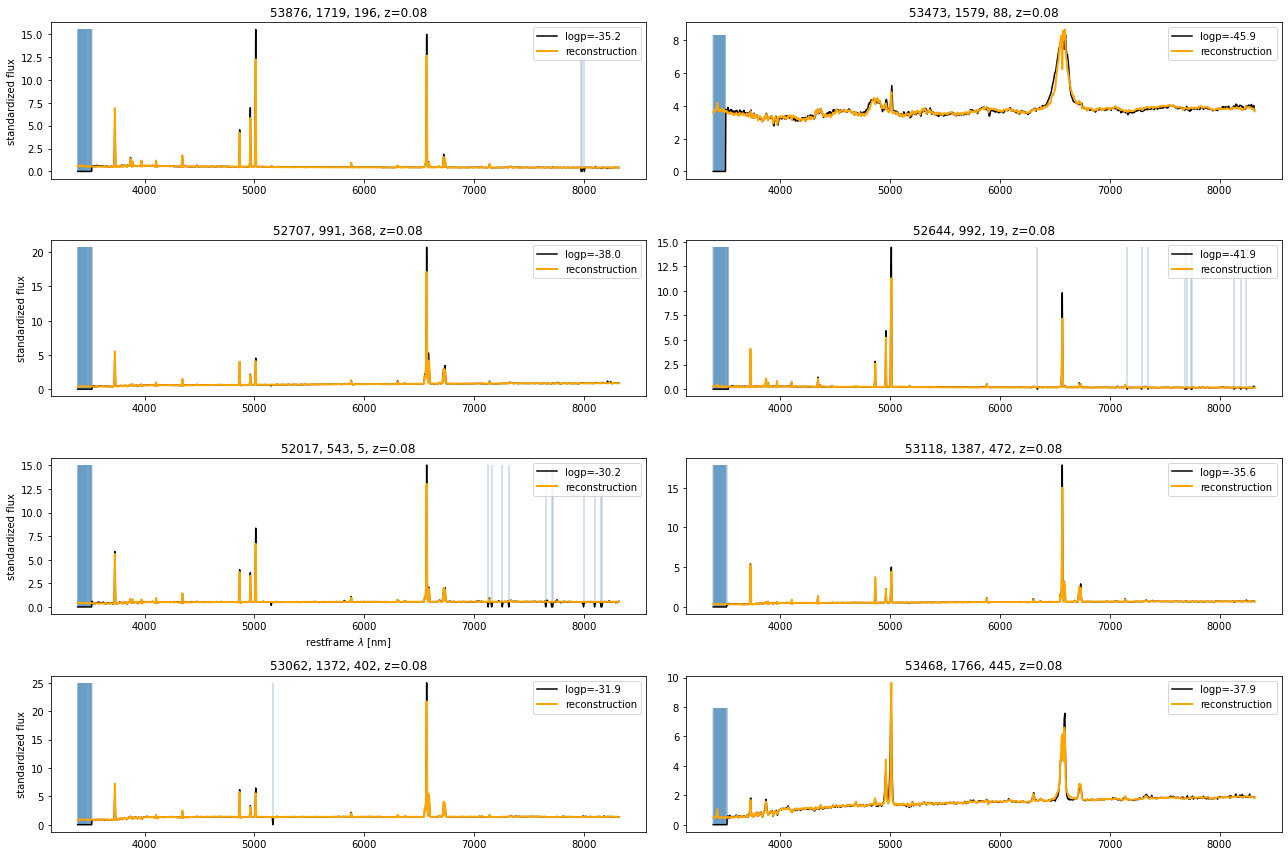

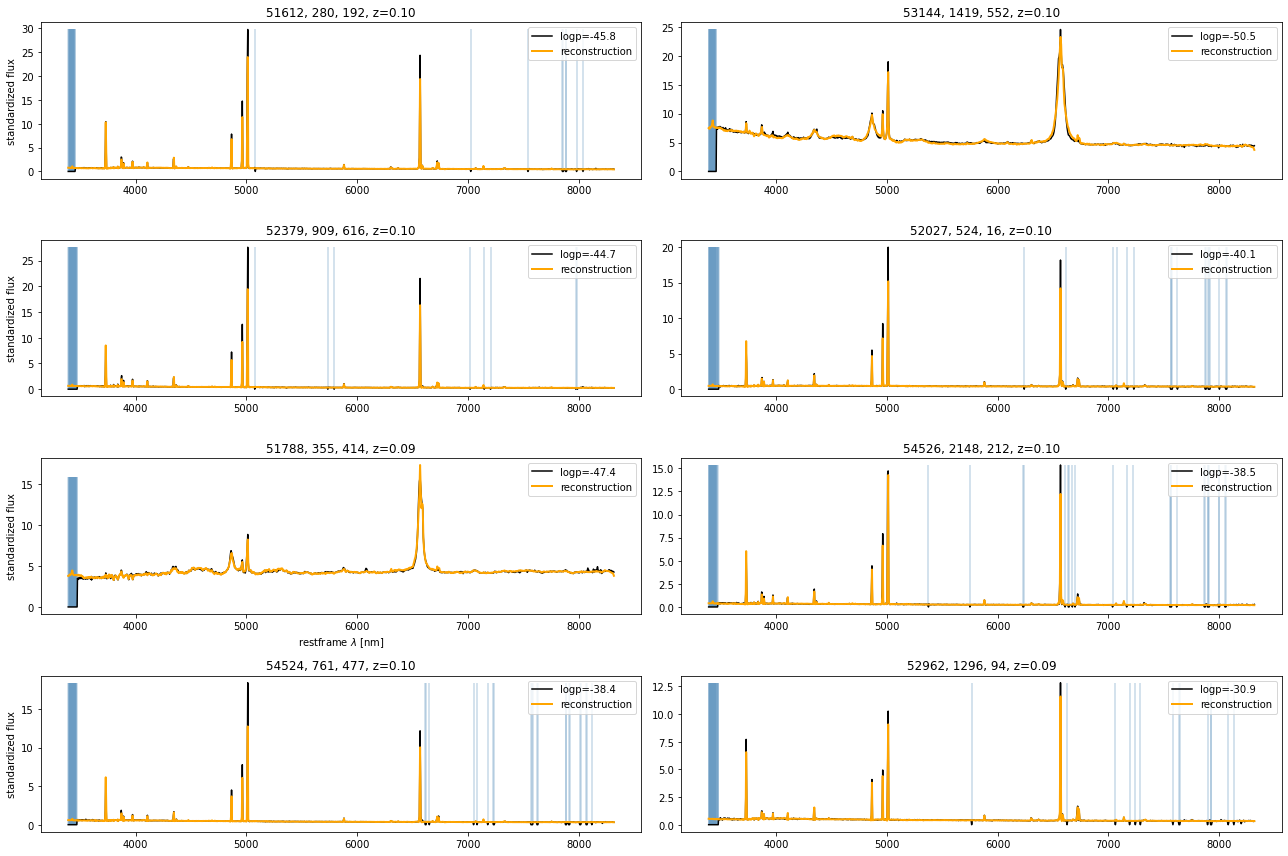

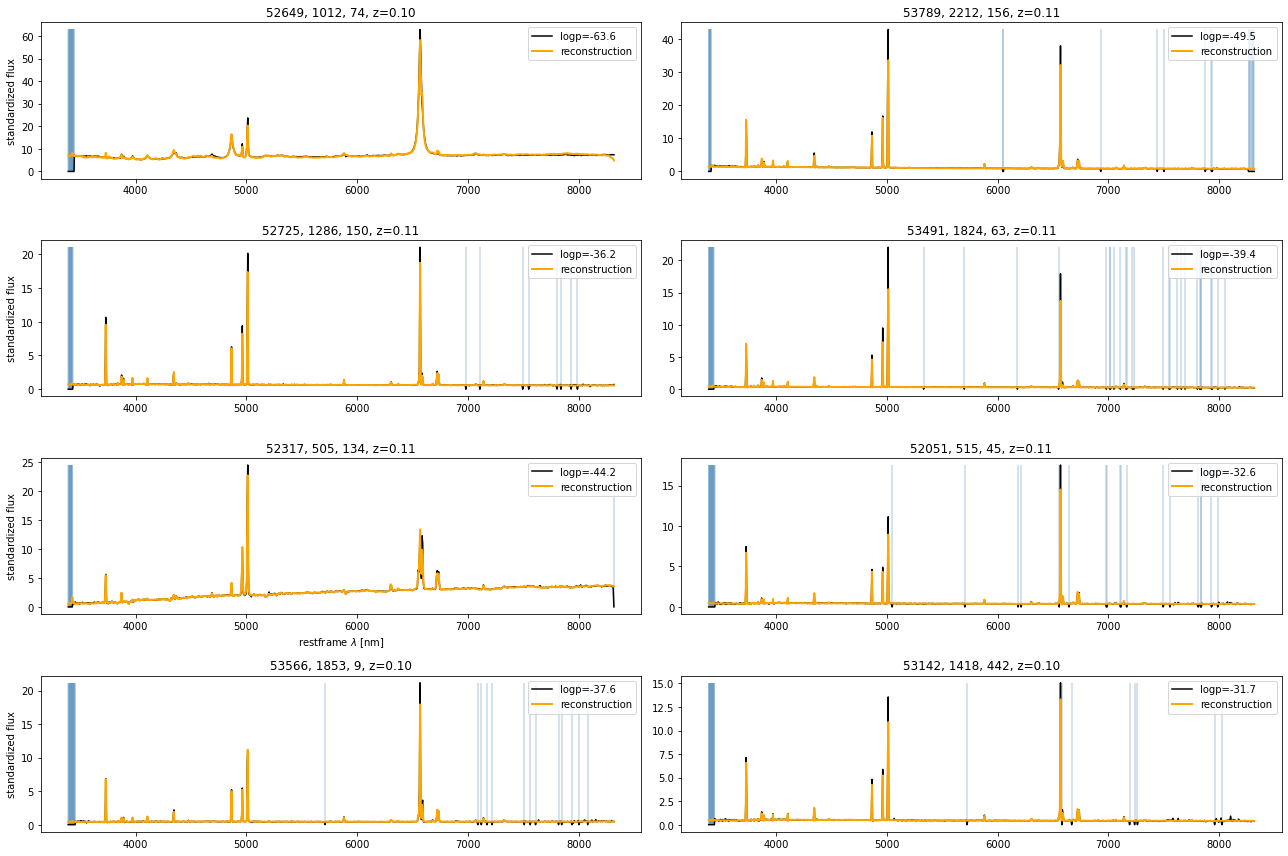

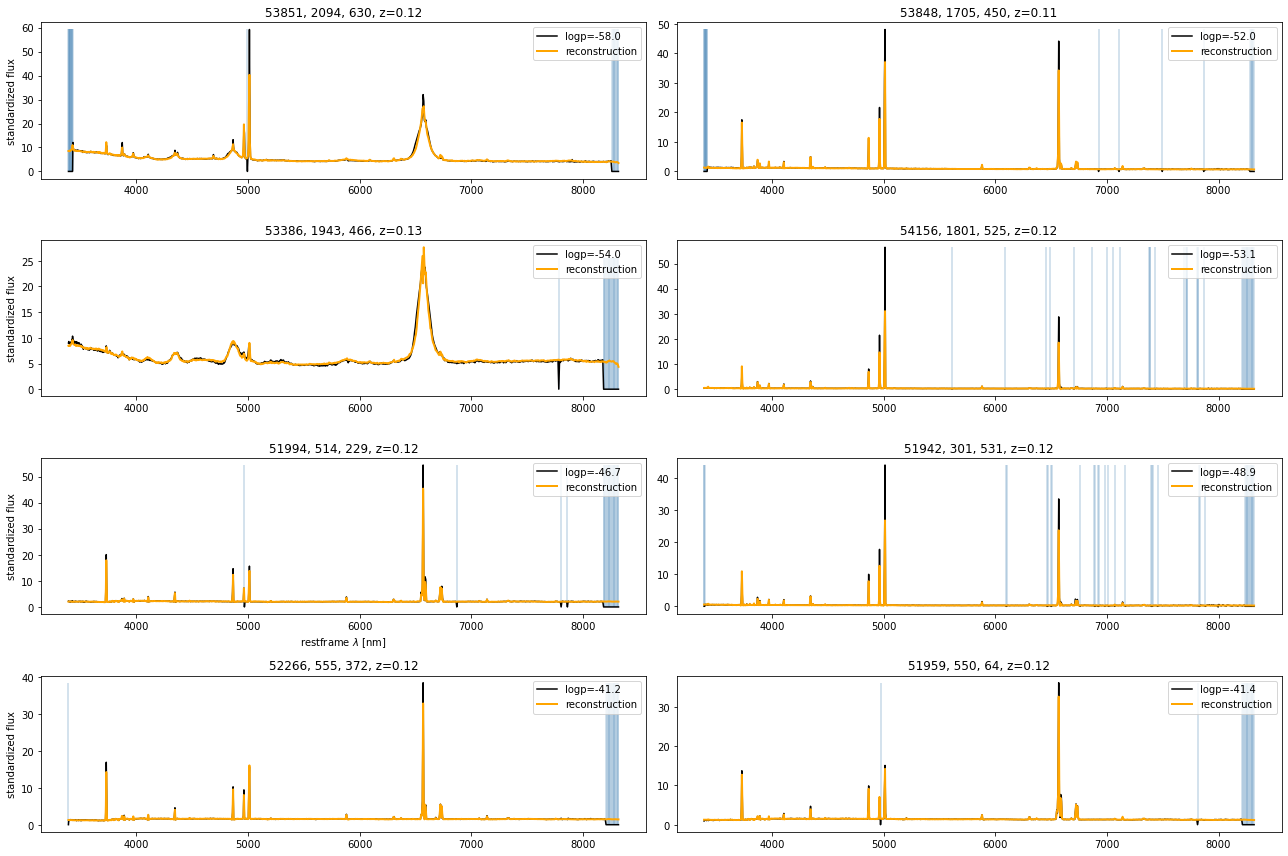

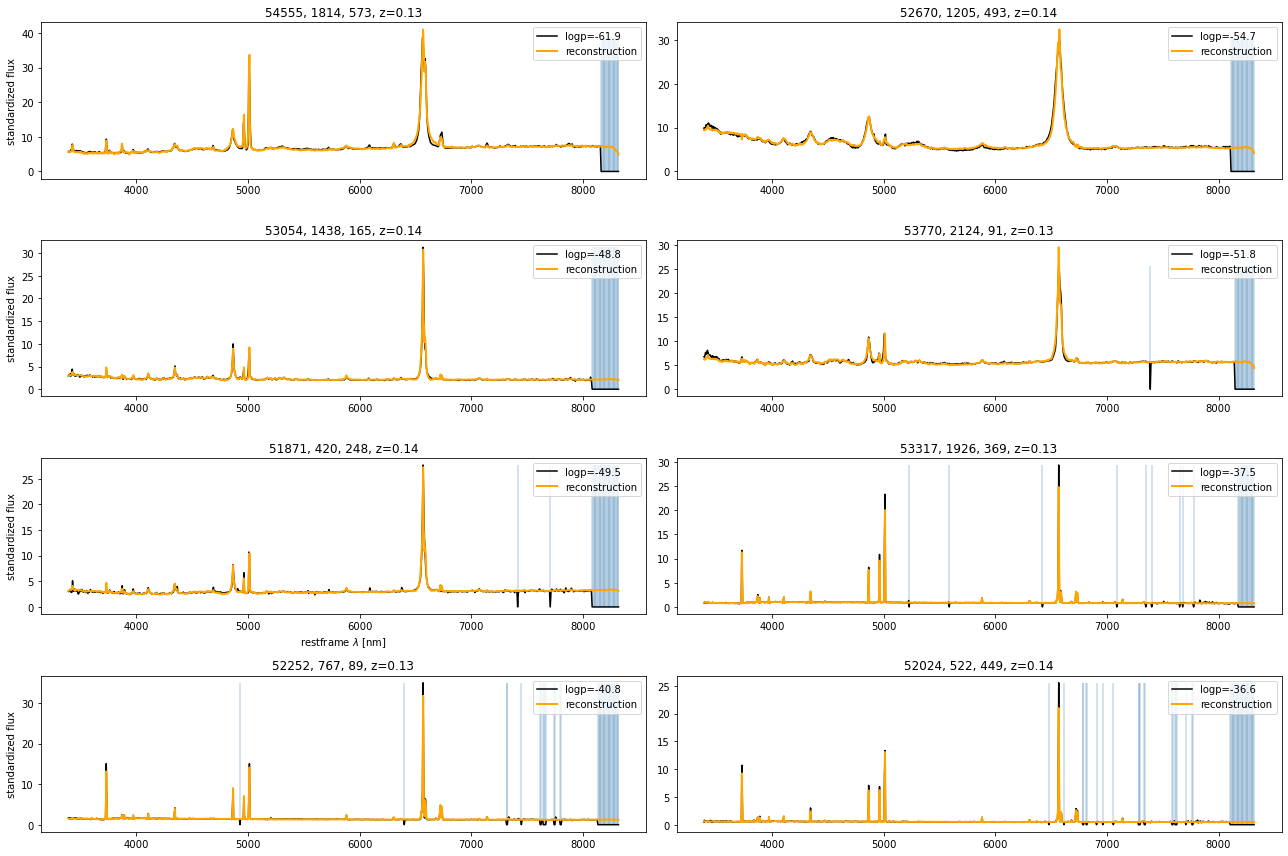

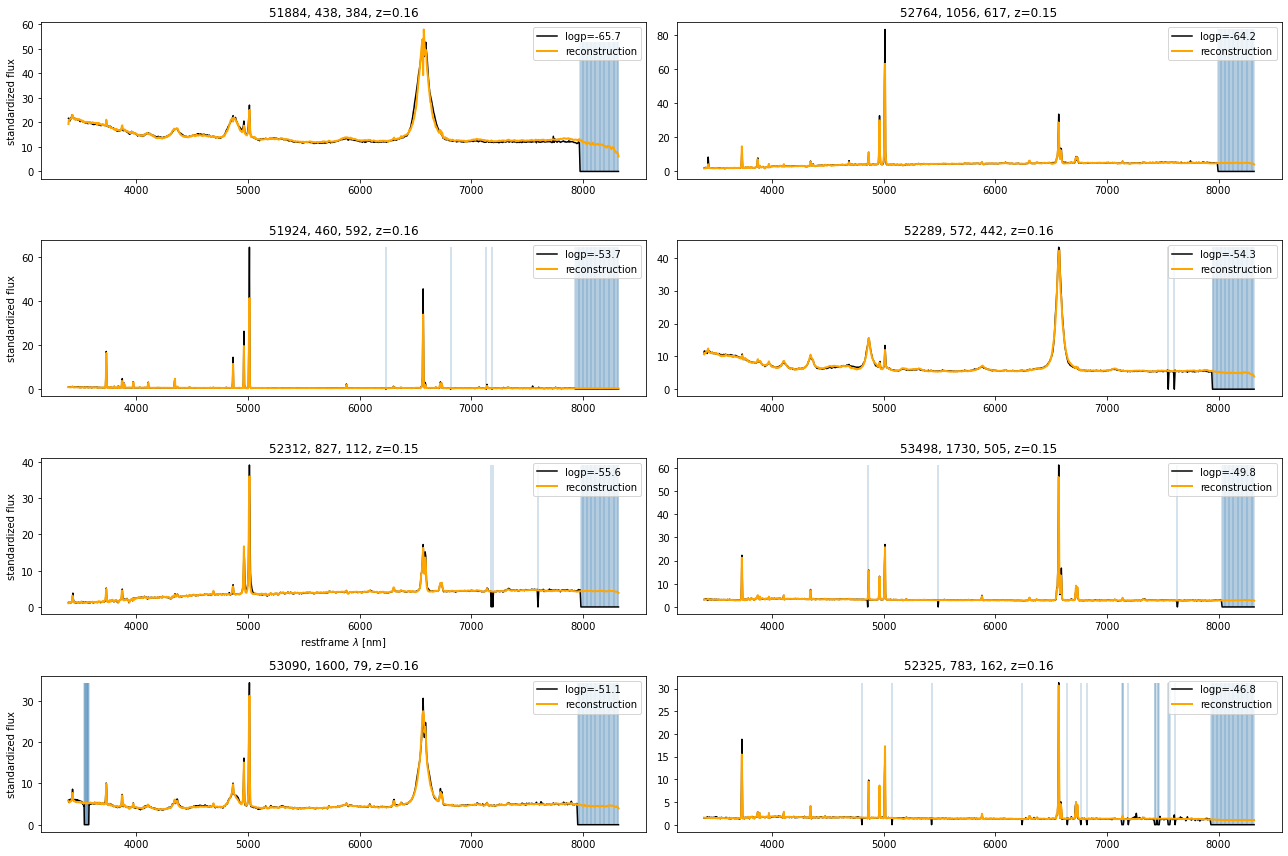

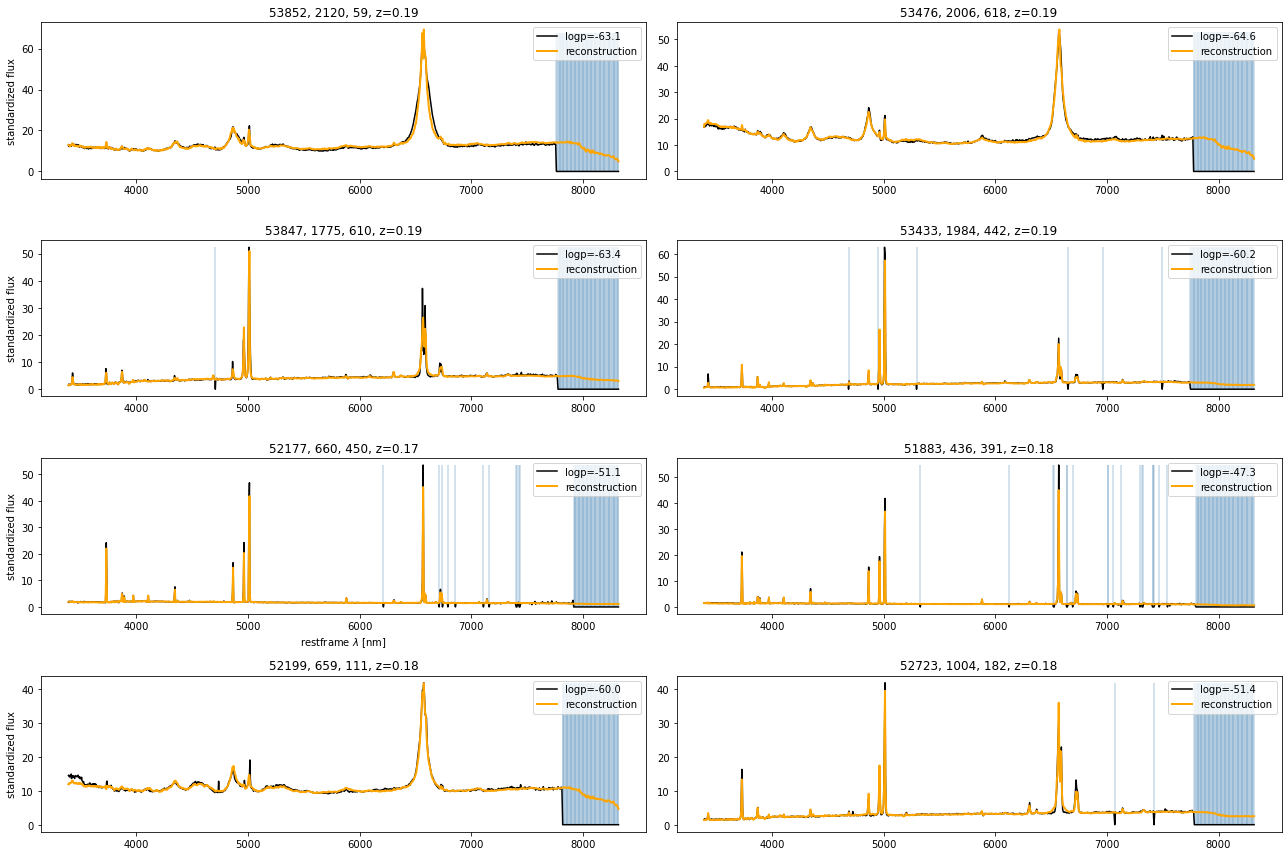

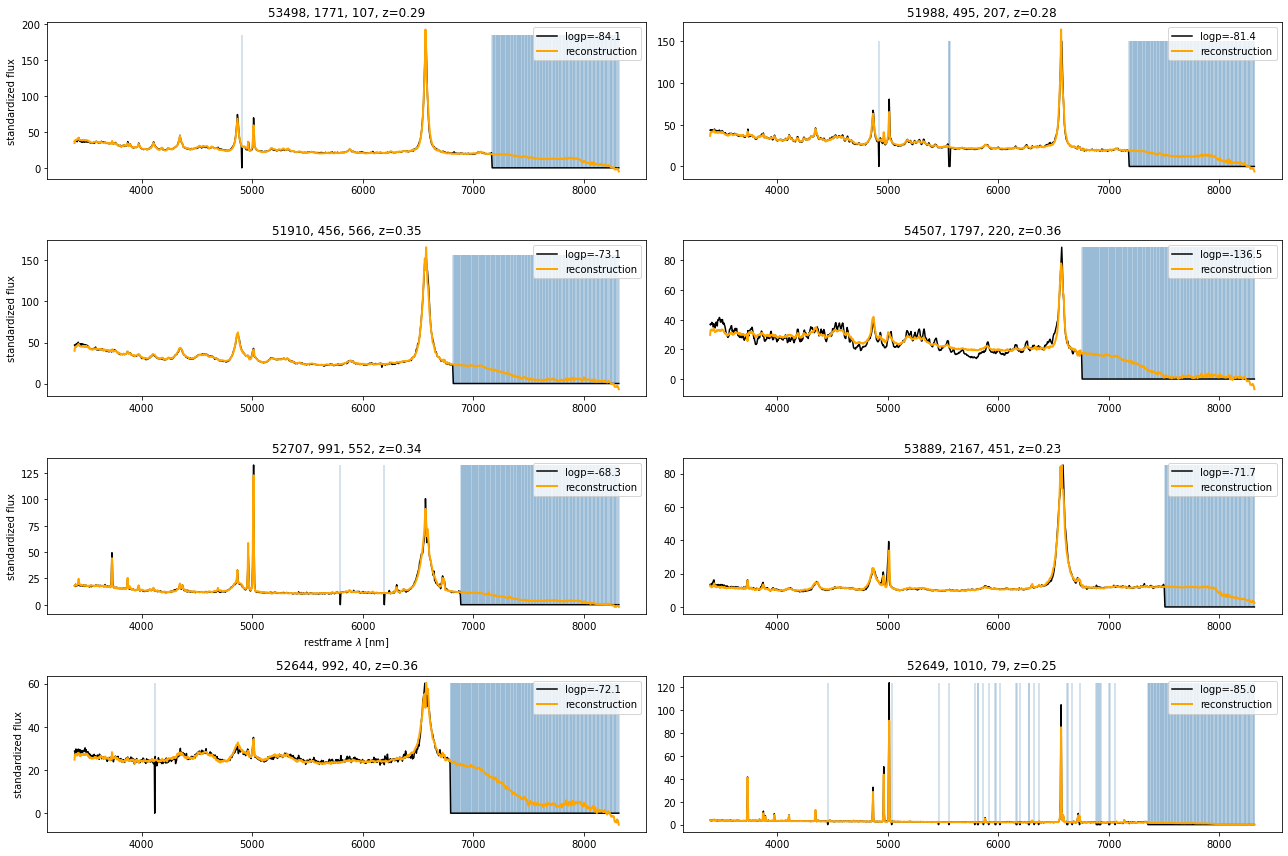

In [61]:
for ii in range(len(ood)):
    fi, ax = plt.subplots(len(ood[ii])//2,2,figsize=(18,12))
    ax     = ax.flatten()
    for jj in range(len(ood[ii])):
        data   = df_valid.iloc[ood[ii].index.values].reset_index()
        ax[jj].set_title('%d, %d, %d, z=%.2f'%(data['MJD'][jj],data['plate'][jj],data['fiber'][jj],data['z'][jj]))
        ax[jj].plot(new_wl[1:],valid['spec'][ood[ii].index.values][jj],label='logp=%.1f'%data['logp_max'][jj], color='black')
        ax[jj].vlines(x=new_wl[1:][np.squeeze(~valid['mask'][ood[ii].index.values][jj].astype(bool))], ymin=0,ymax=max(valid['spec'][ood[ii].index.values][jj]), color='steelblue',alpha=0.3)
        ax[jj].plot(new_wl[1:],np.squeeze(decoded_valid[ood[ii].index.values][jj]), label='reconstruction',ls='-', color='orange', lw=2)
        ax[jj].legend()
        if jj in [4,8]:
            ax[jj].set_xlabel(r'restframe $\lambda$ [nm]')
        if jj%2==0:
            ax[jj].set_ylabel(r'standardized flux')        
    plt.tight_layout()
    #plt.savefig(os.path.join(plotpath,'relabeled_retrained/logp/','logp_outliers_class_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
    plt.show()
    plt.close()

In [63]:
bin_edges, ood = split_in_equal_bins(df_valid, 10, 'z', 'logp_marg_flat_prior', 0.0011)

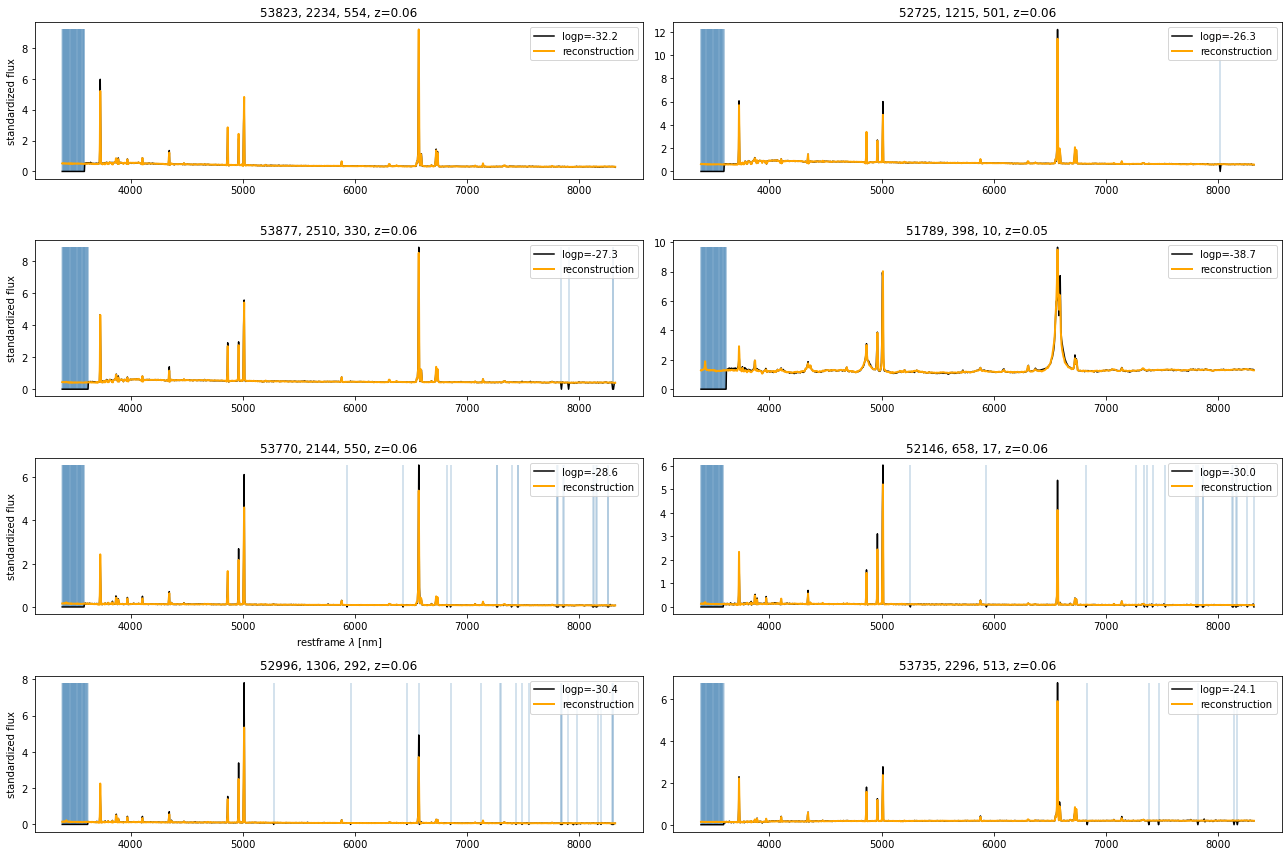

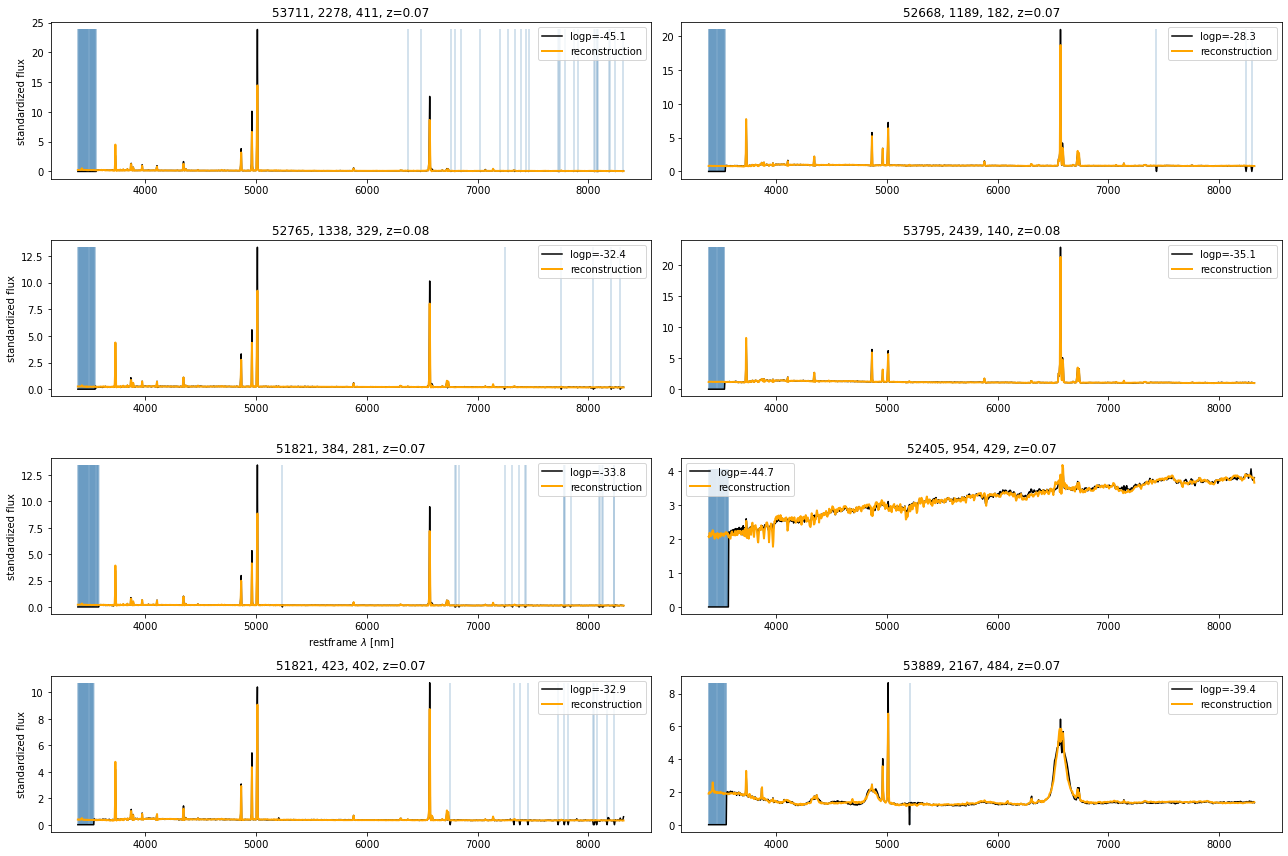

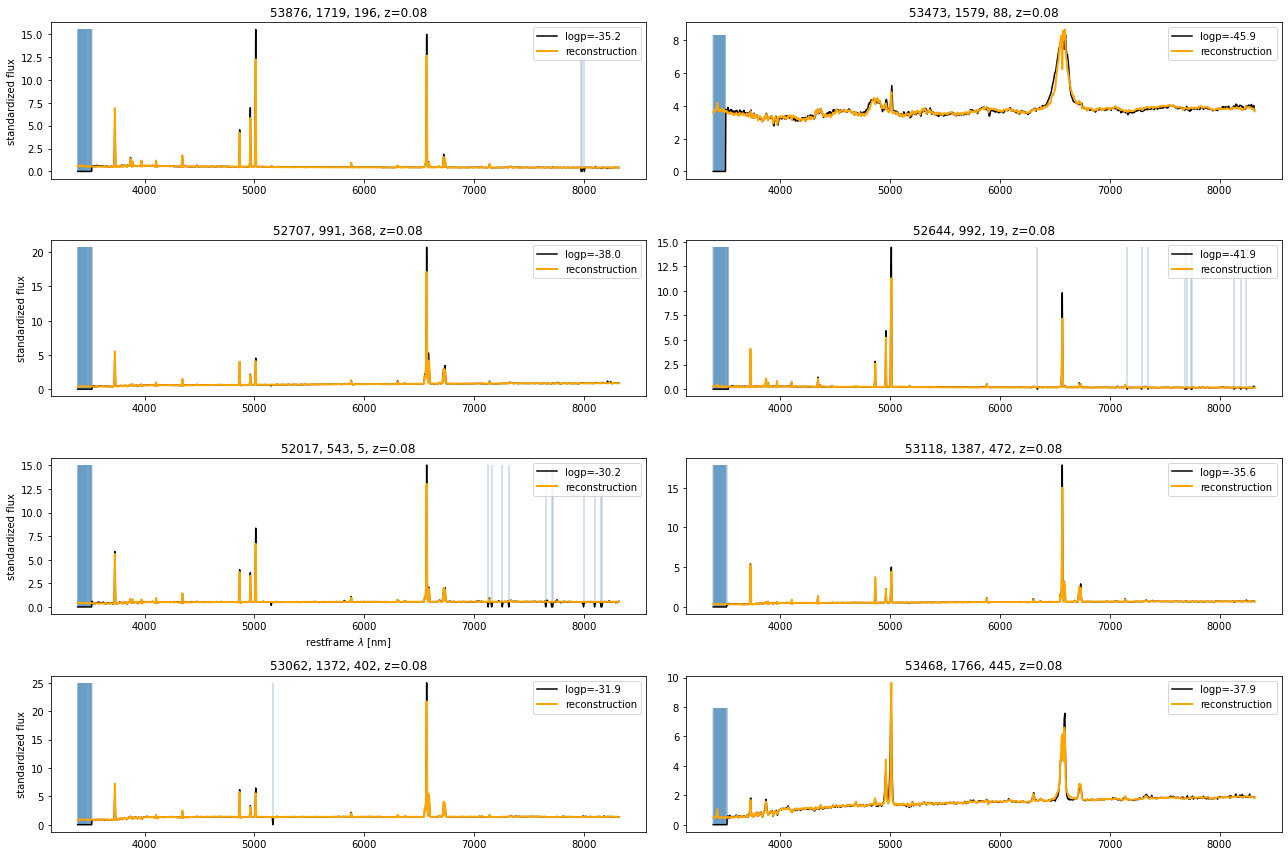

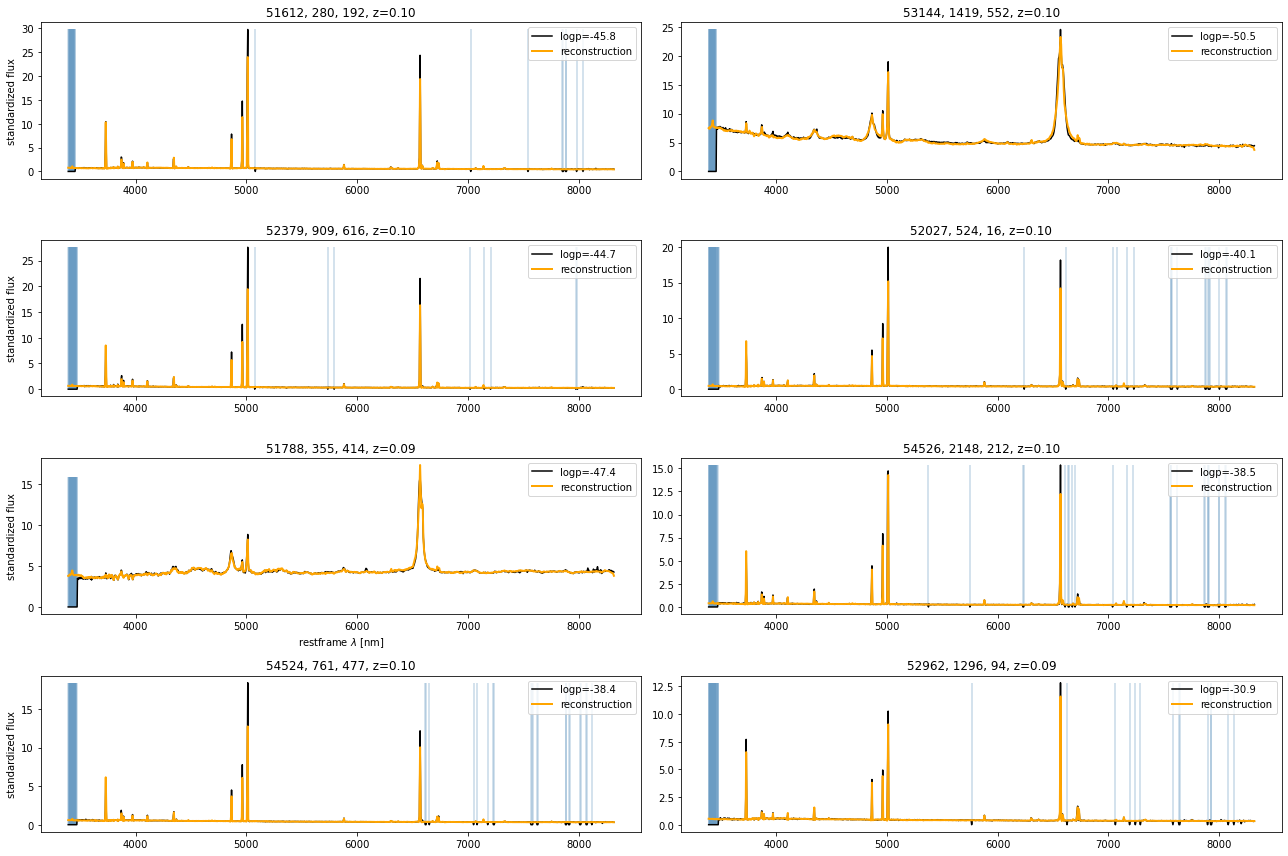

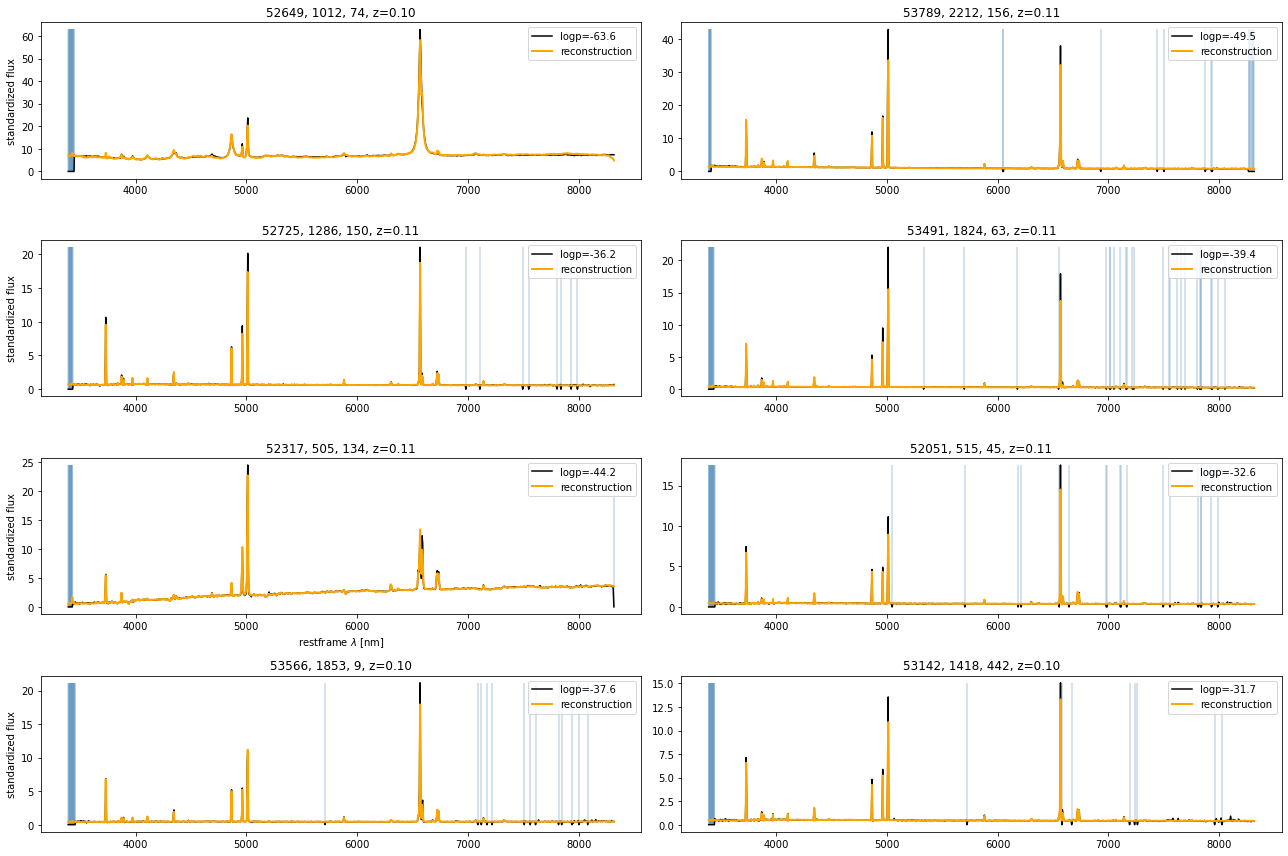

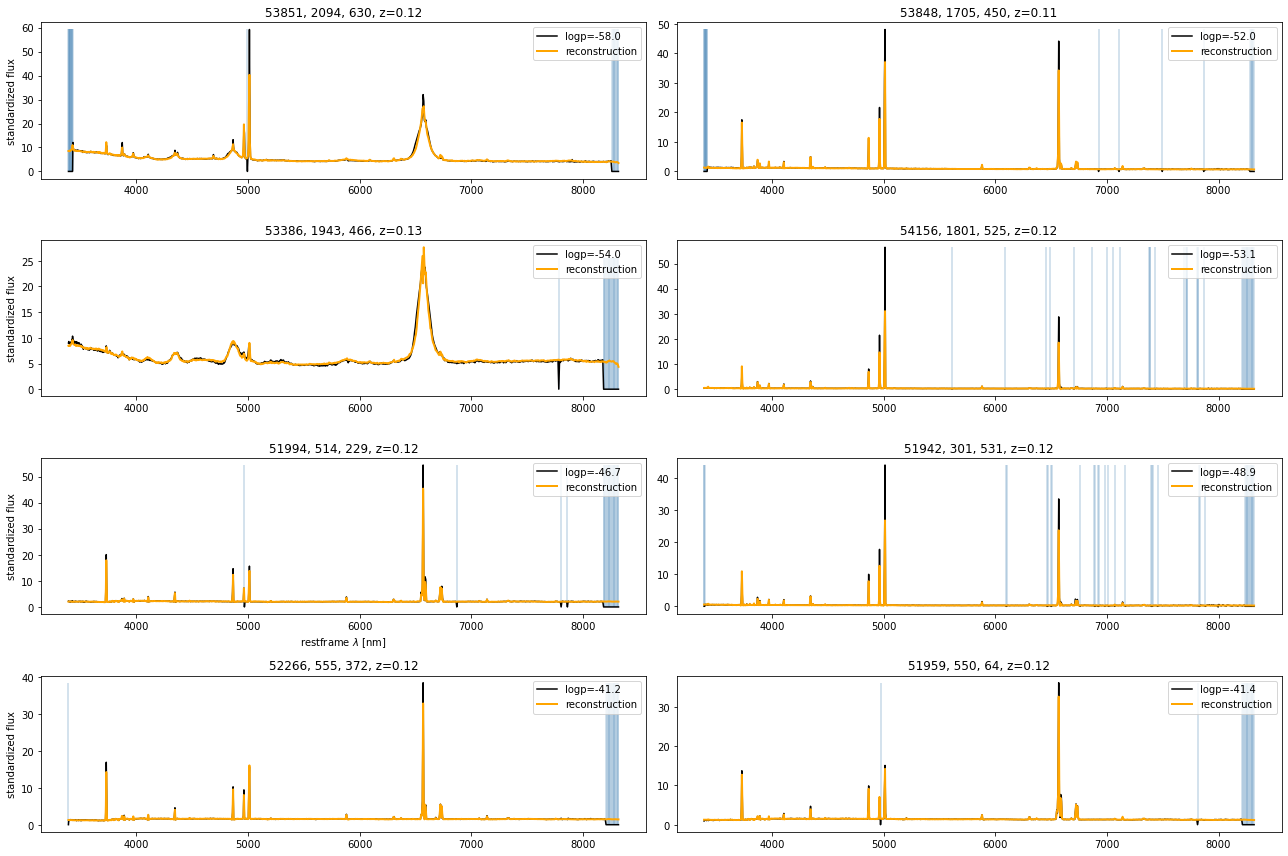

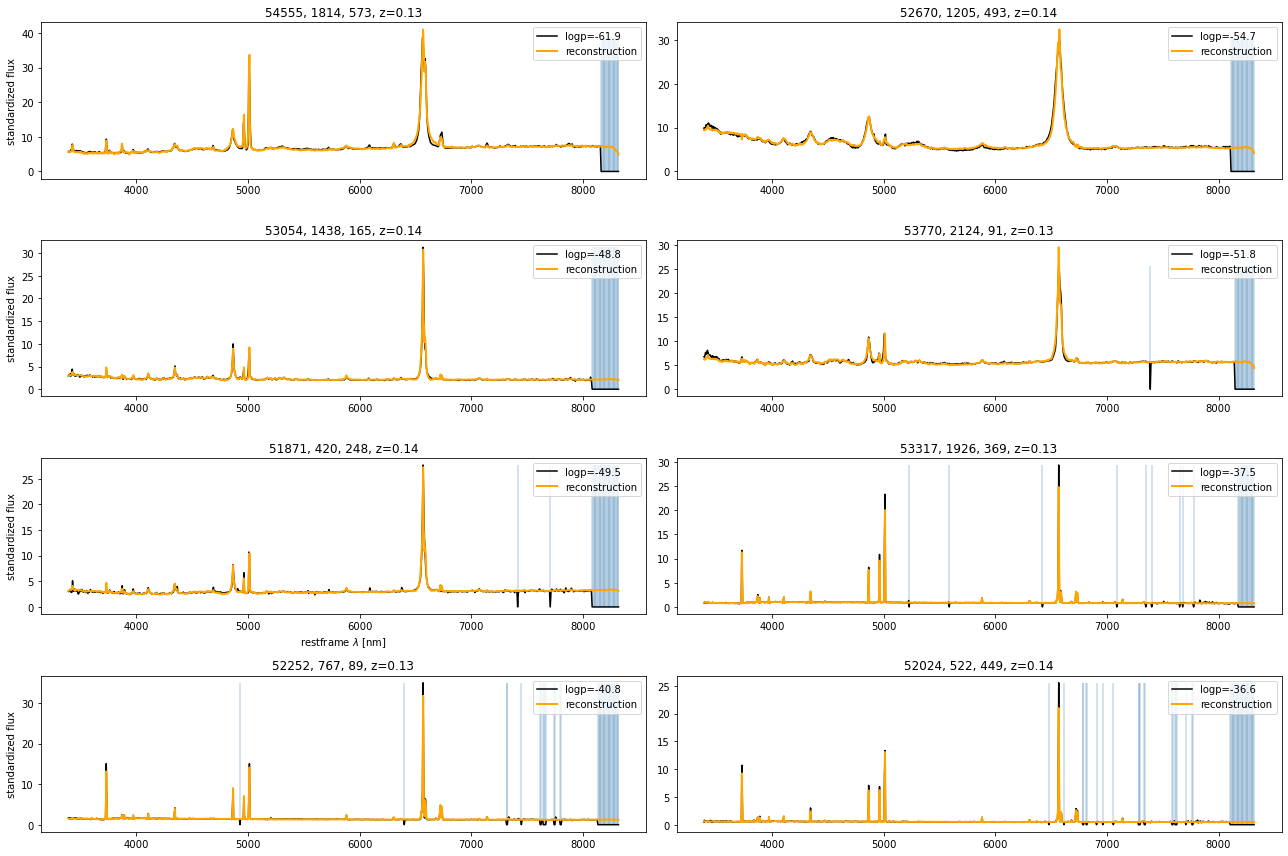

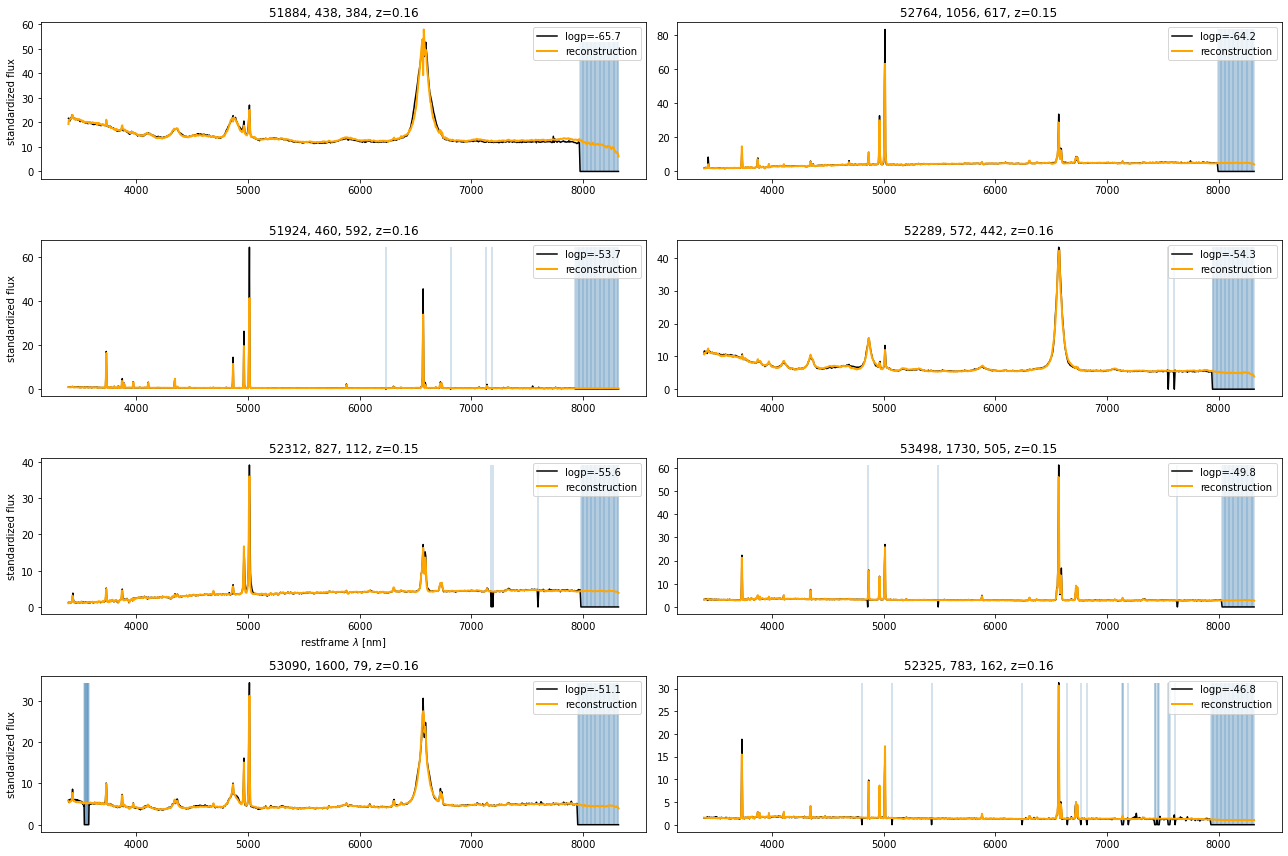

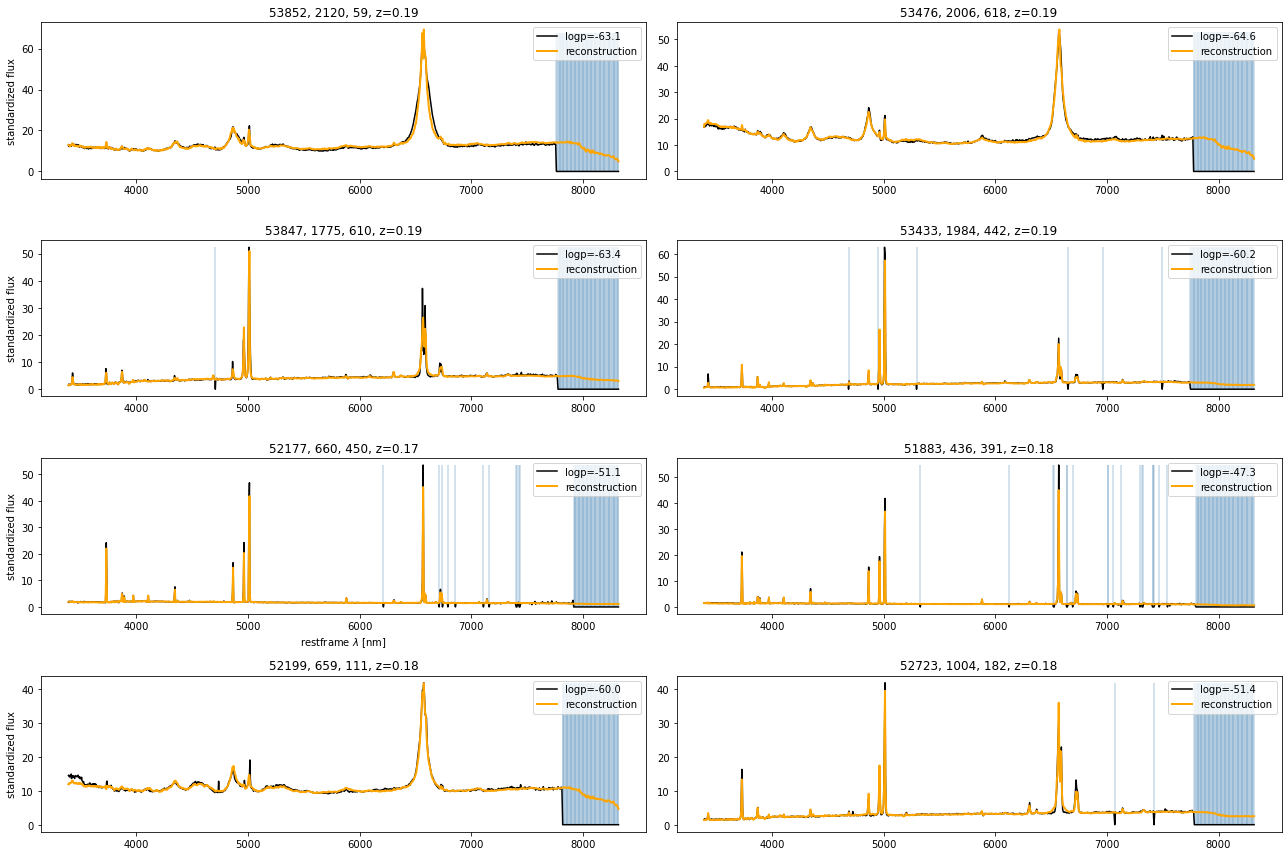

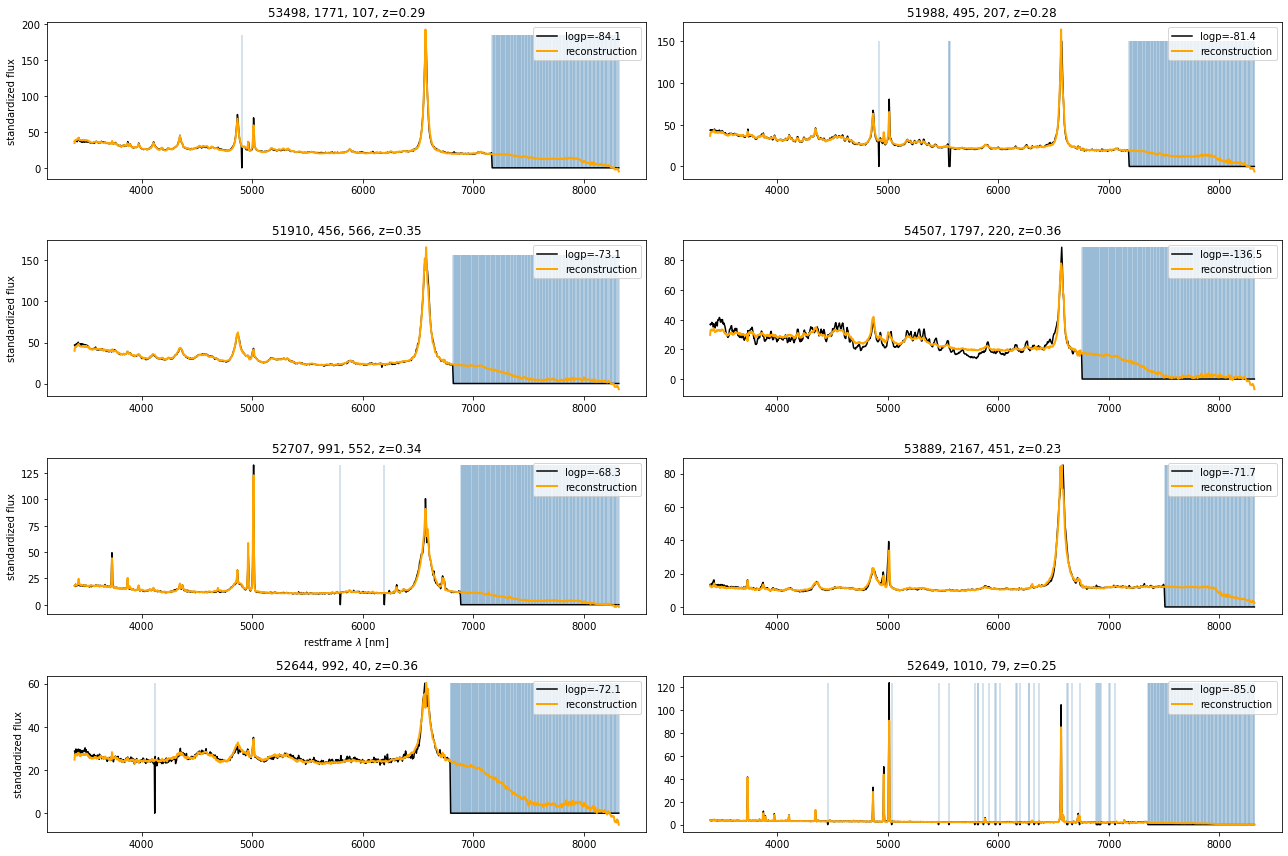

In [64]:
for ii in range(len(ood)):
    fi, ax = plt.subplots(len(ood[ii])//2,2,figsize=(18,12))
    ax     = ax.flatten()
    for jj in range(len(ood[ii])):
        data   = df_valid.iloc[ood[ii].index.values].reset_index()
        ax[jj].set_title('%d, %d, %d, z=%.2f'%(data['MJD'][jj],data['plate'][jj],data['fiber'][jj],data['z'][jj]))
        ax[jj].plot(new_wl[1:],valid['spec'][ood[ii].index.values][jj],label='logp=%.1f'%data['logp_max'][jj], color='black')
        ax[jj].vlines(x=new_wl[1:][np.squeeze(~valid['mask'][ood[ii].index.values][jj].astype(bool))], ymin=0,ymax=max(valid['spec'][ood[ii].index.values][jj]), color='steelblue',alpha=0.3)
        ax[jj].plot(new_wl[1:],np.squeeze(decoded_valid[ood[ii].index.values][jj]), label='reconstruction',ls='-', color='orange', lw=2)
        ax[jj].legend()
        if jj in [4,8]:
            ax[jj].set_xlabel(r'restframe $\lambda$ [nm]')
        if jj%2==0:
            ax[jj].set_ylabel(r'standardized flux')        
    plt.tight_layout()
    #plt.savefig(os.path.join(plotpath,'relabeled_retrained/logp/','logp_outliers_class_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
    plt.show()
    plt.close()

In [34]:
bin_edges, ood = split_in_equal_bins(df_valid[(valid['new_inf_labels']==0)|(valid['new_inf_labels']==1)], 10, 'z', 'logp_max', 0.0018)

In [35]:
len(ood[0])

8

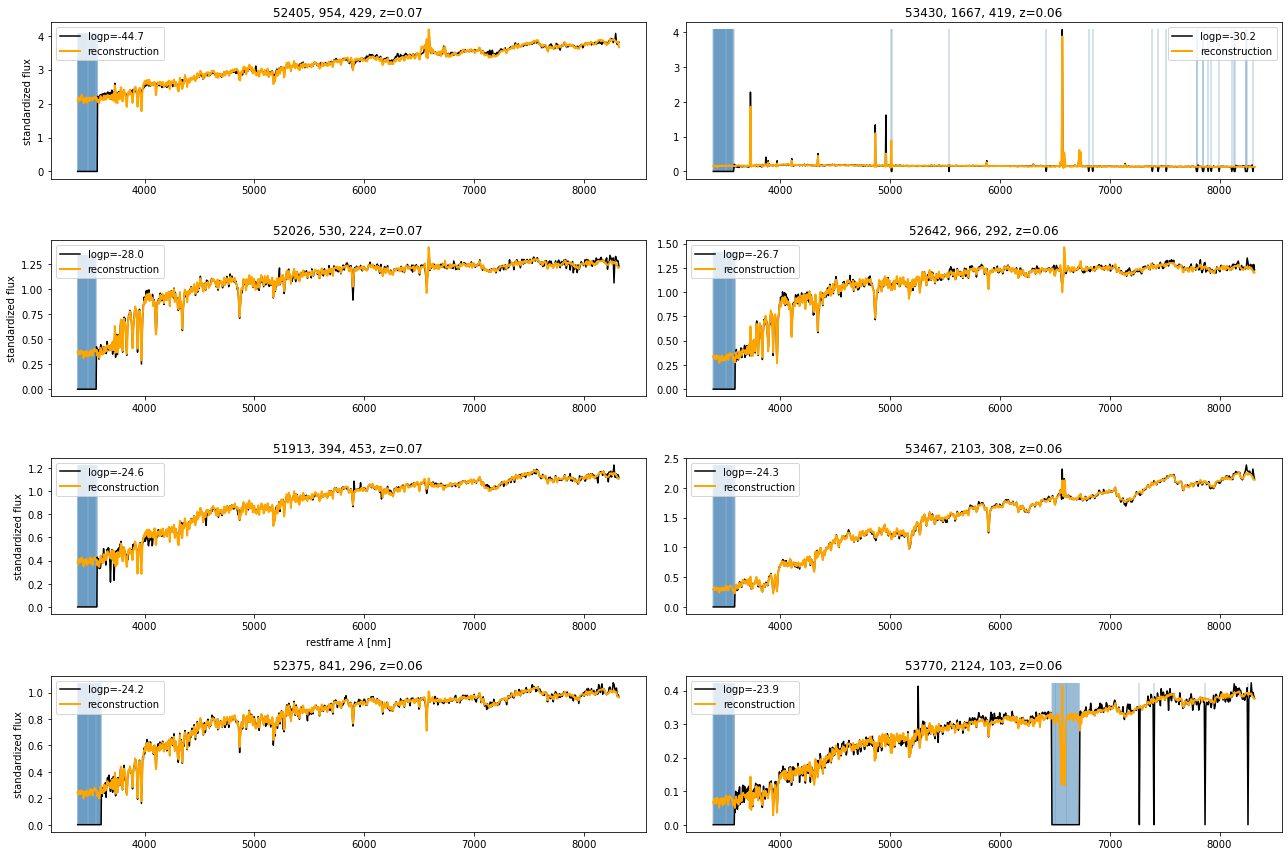

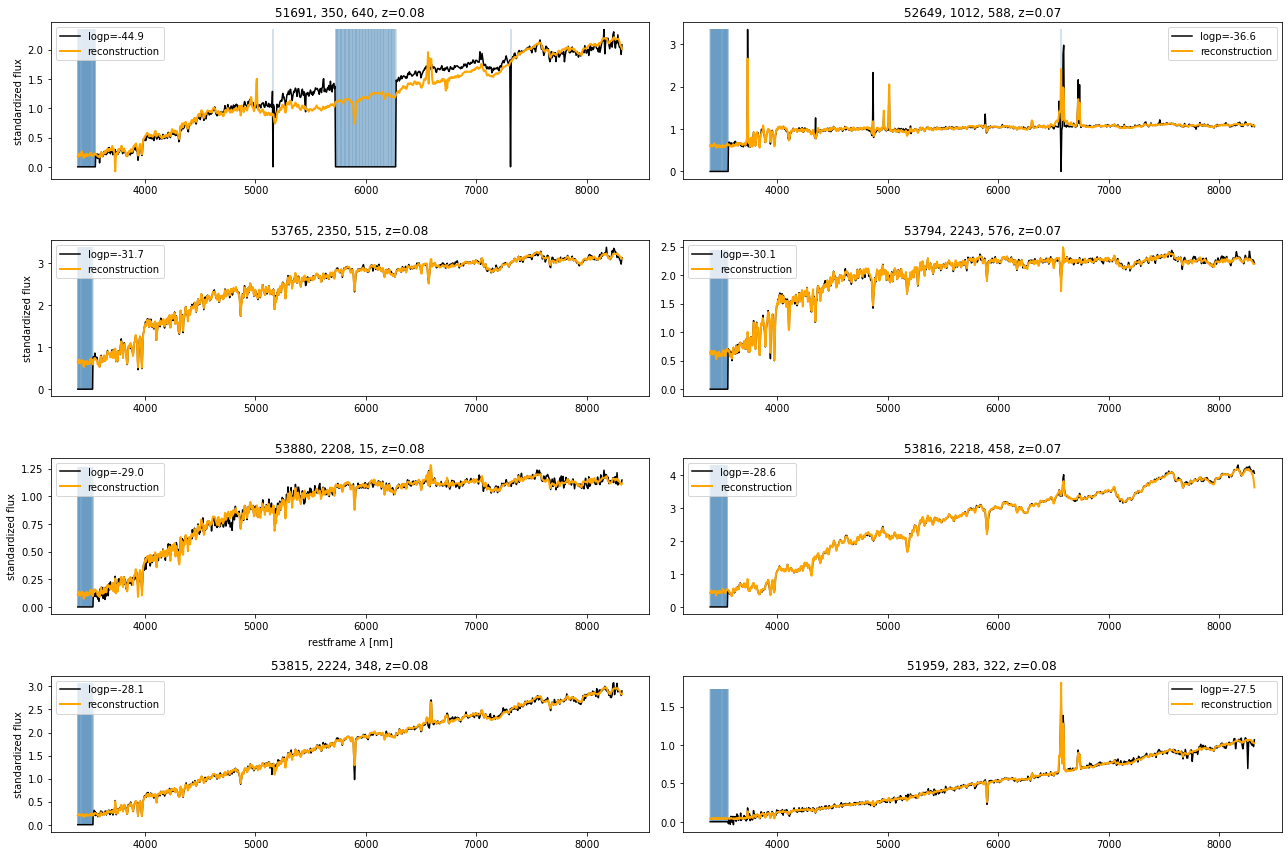

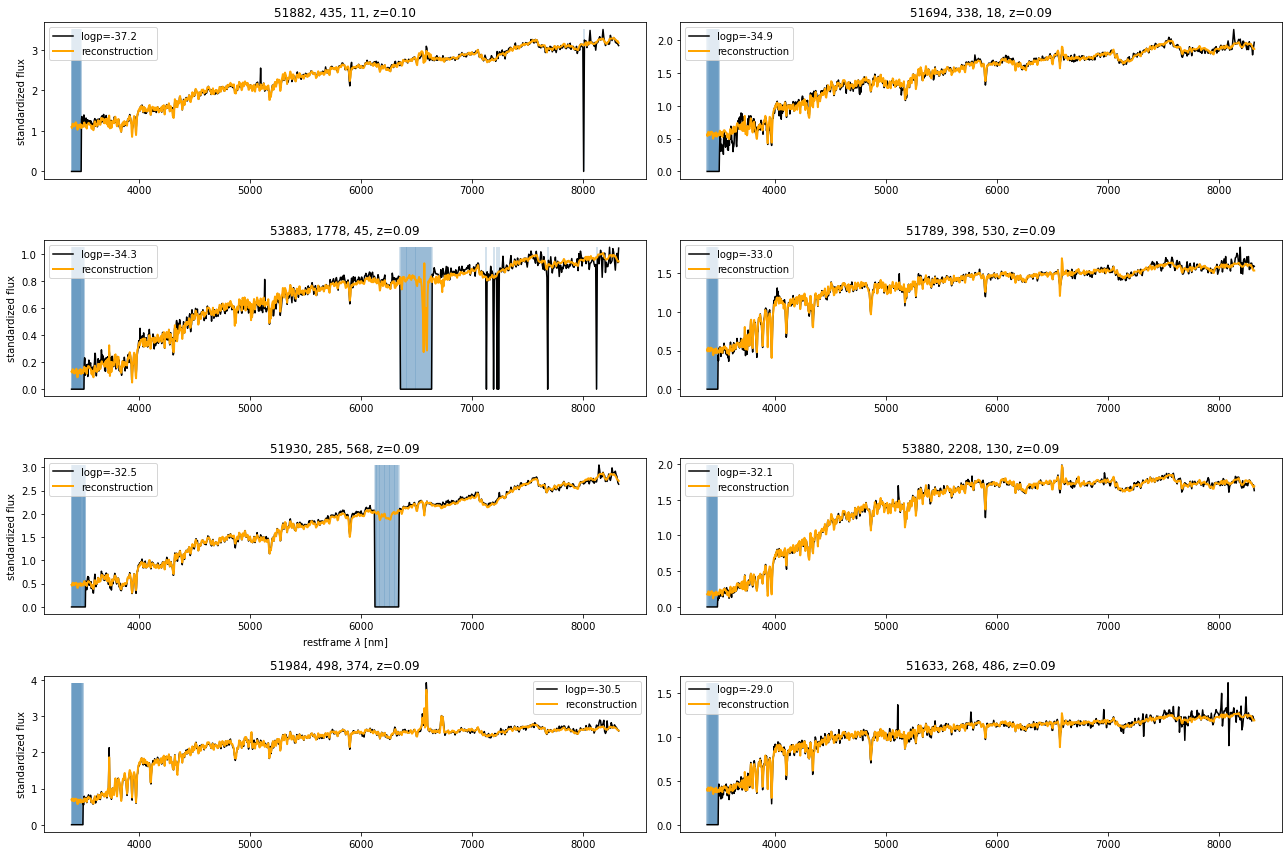

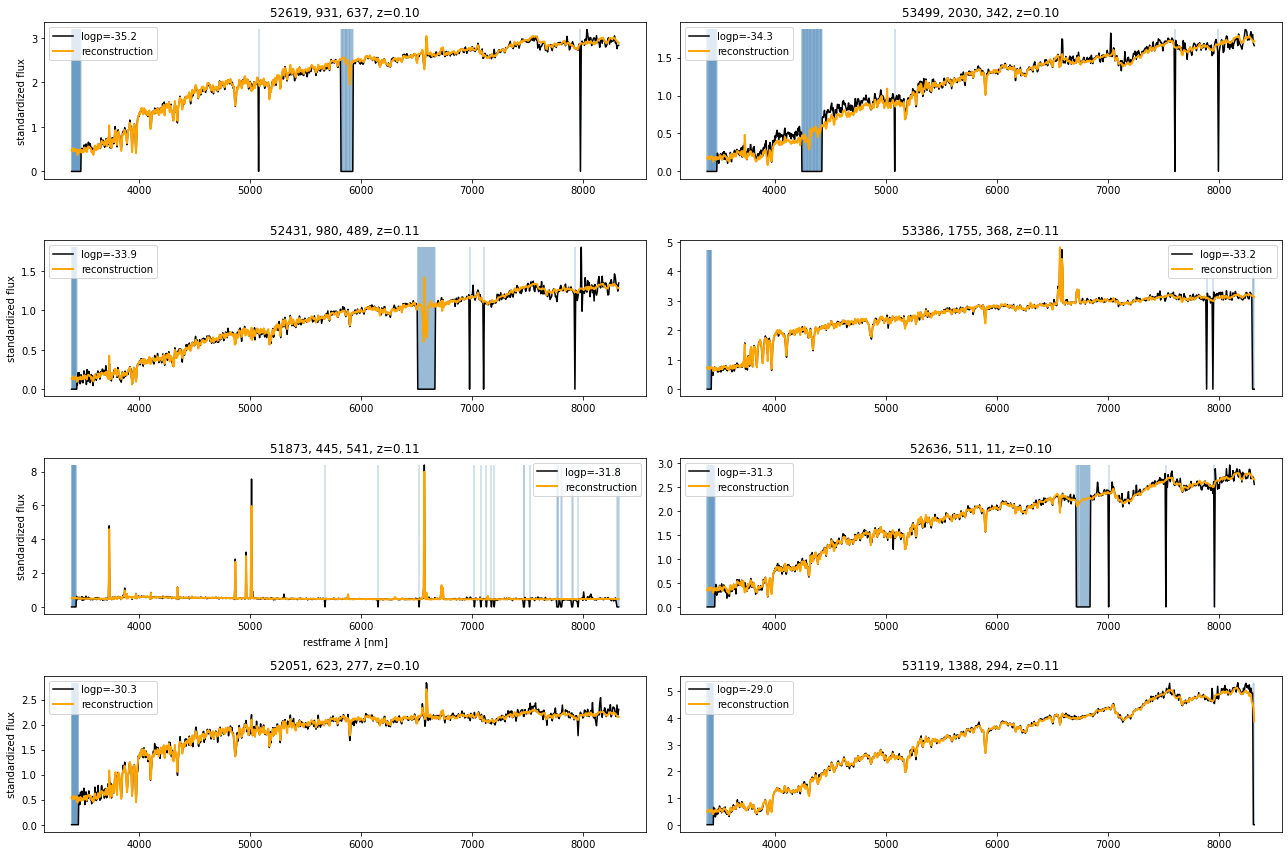

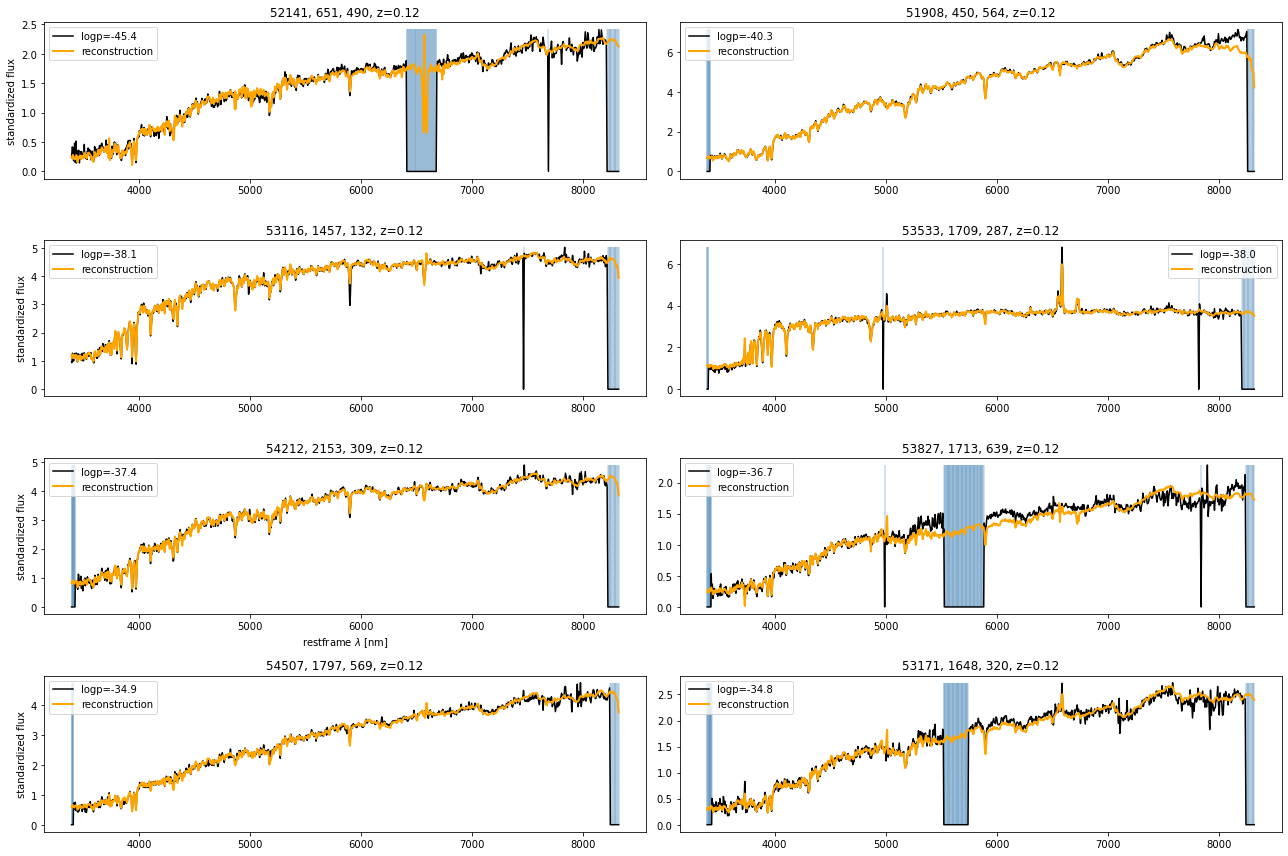

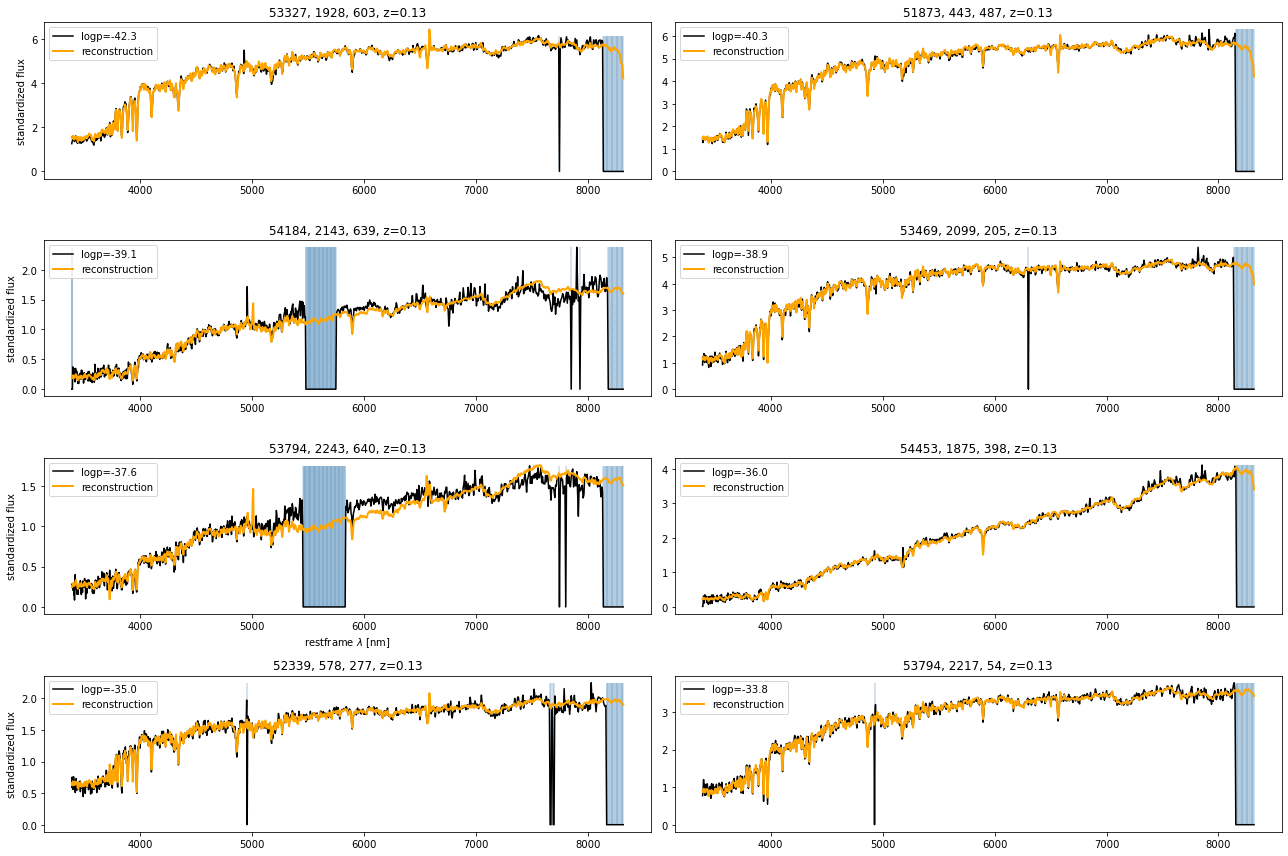

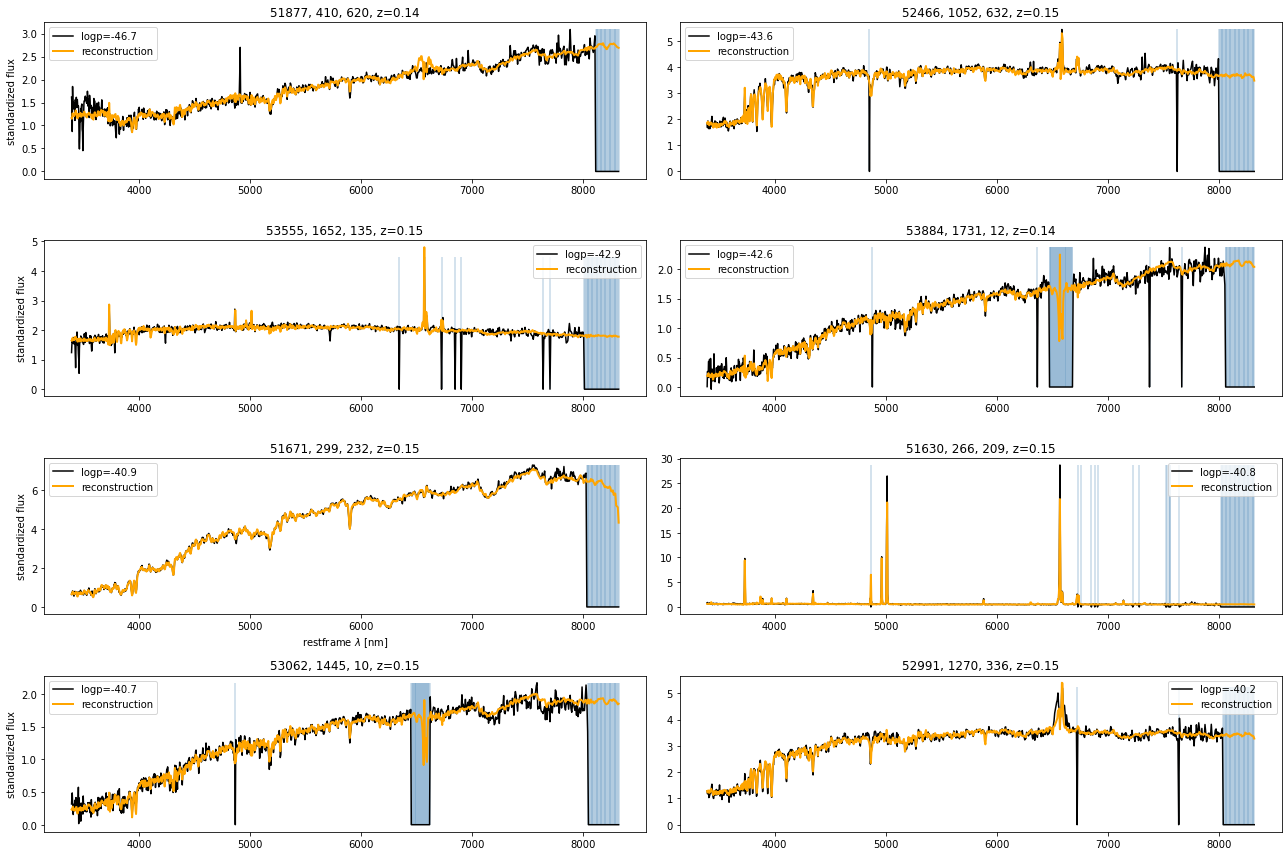

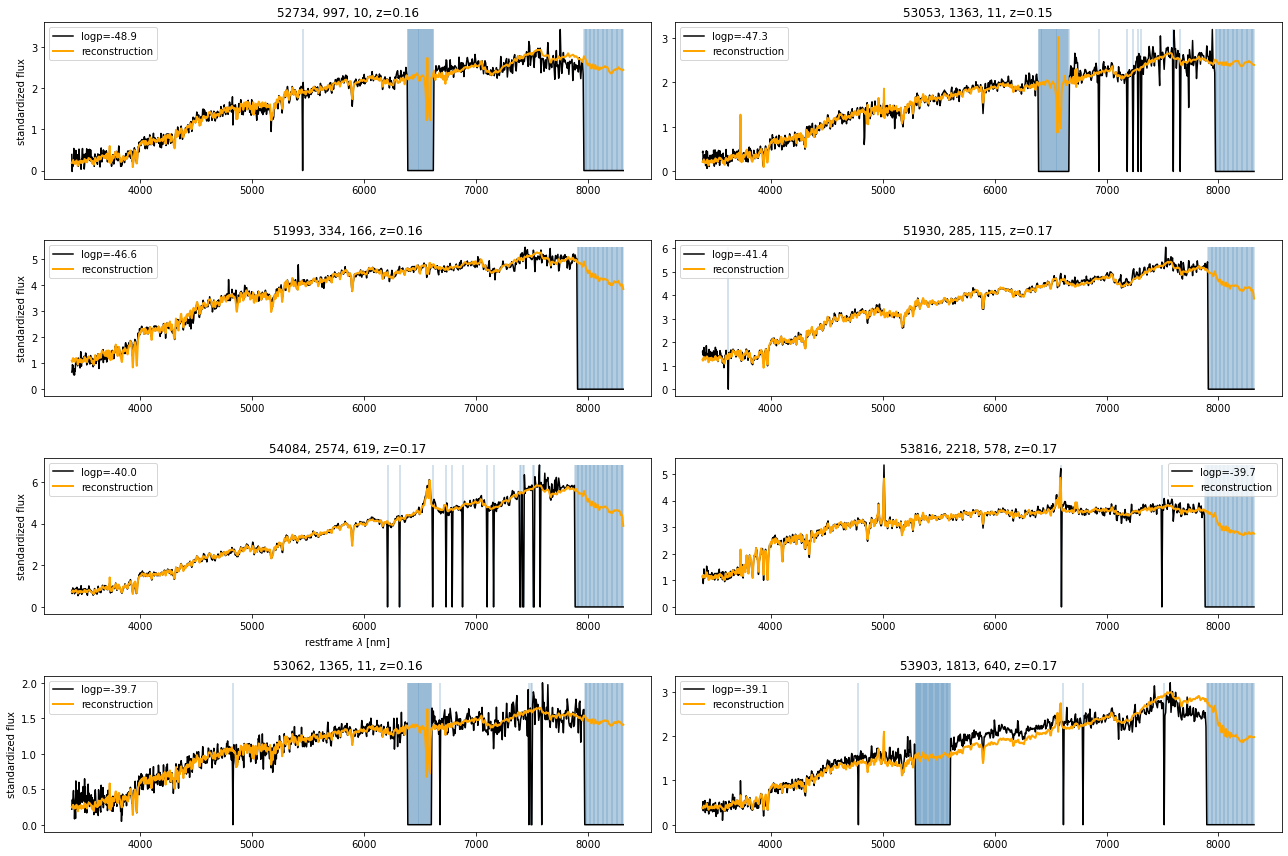

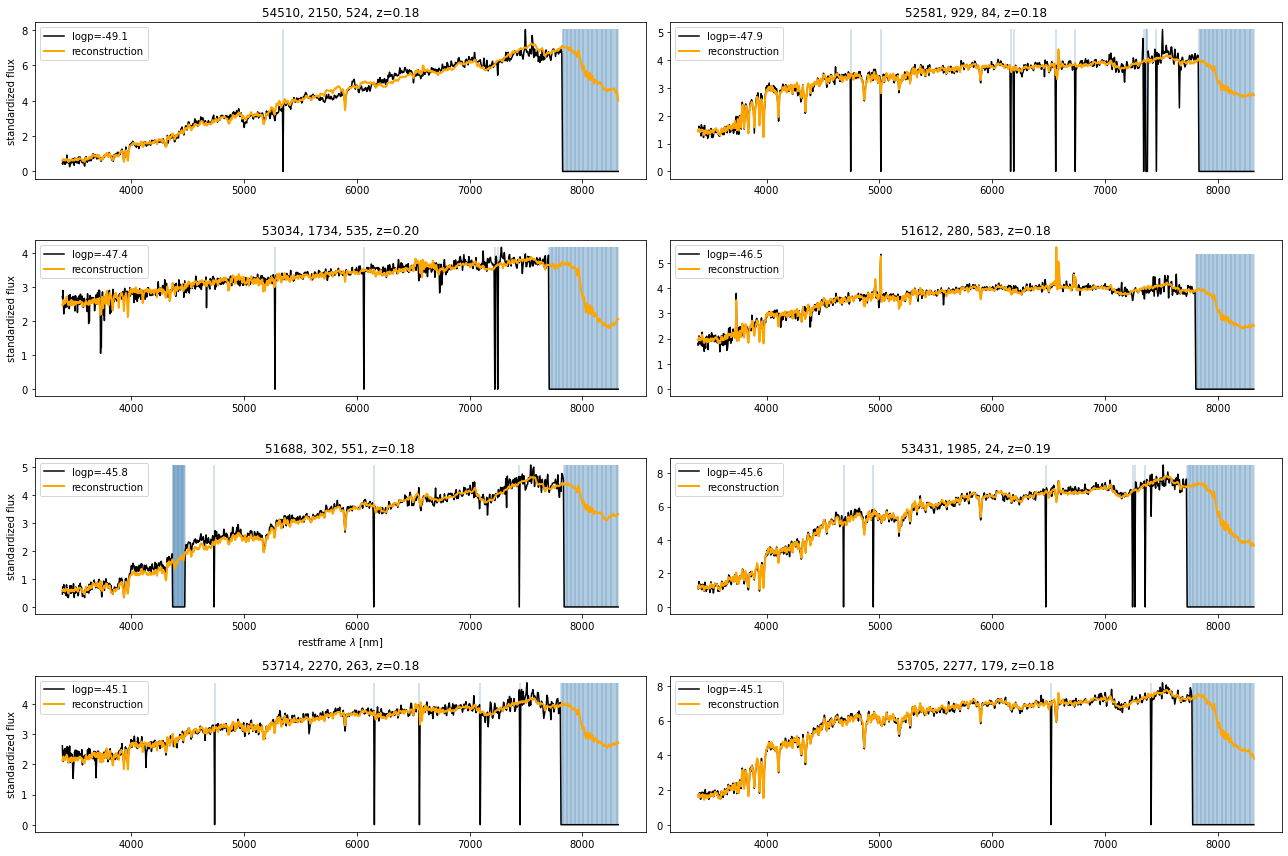

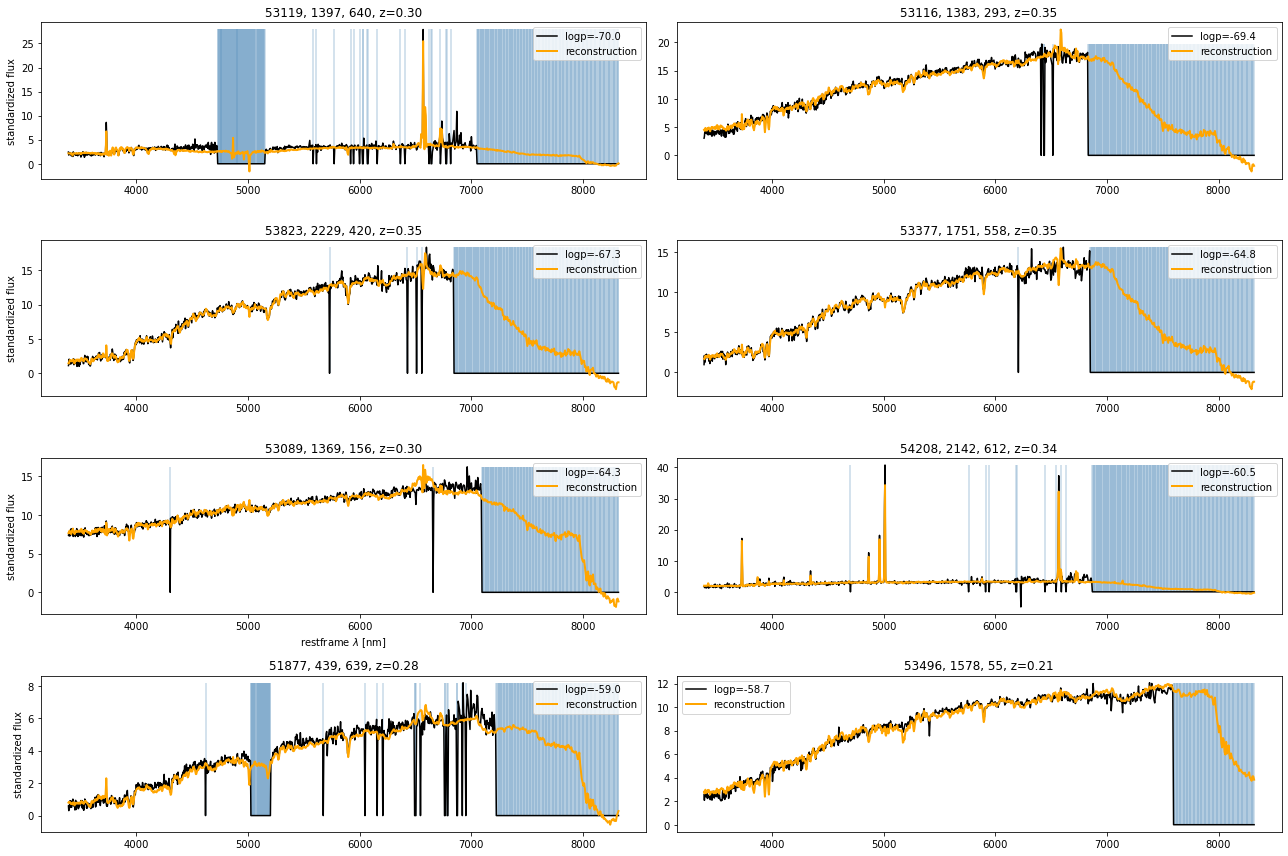

In [38]:
for ii in range(len(ood)):
    fi, ax = plt.subplots(len(ood[ii])//2,2,figsize=(18,12))
    ax     = ax.flatten()
    for jj in range(len(ood[ii])):
        data   = df_valid.iloc[ood[ii].index.values].reset_index()
        ax[jj].set_title('%d, %d, %d, z=%.2f'%(data['MJD'][jj],data['plate'][jj],data['fiber'][jj],data['z'][jj]))
        ax[jj].plot(new_wl[1:],valid['spec'][ood[ii].index.values][jj],label='logp=%.1f'%data['logp_max'][jj], color='black')
        ax[jj].vlines(x=new_wl[1:][np.squeeze(~valid['mask'][ood[ii].index.values][jj].astype(bool))], ymin=0,ymax=max(valid['spec'][ood[ii].index.values][jj]), color='steelblue',alpha=0.3)
        ax[jj].plot(new_wl[1:],np.squeeze(decoded_valid[ood[ii].index.values][jj]), label='reconstruction',ls='-', color='orange', lw=2)
        ax[jj].legend()
        if jj in [4,8]:
            ax[jj].set_xlabel(r'restframe $\lambda$ [nm]')
        if jj%2==0:
            ax[jj].set_ylabel(r'standardized flux')        
    plt.tight_layout()
    #plt.savefig(os.path.join(plotpath,'relabeled_retrained/logp/','logp_outliers_class_%s_%s.pdf'%(name,(le.inverse_transform([mm])[0]).decode('utf8'))), bbox_inches='tight')
    plt.show()
    plt.close()